In [7]:
import numpy as np
import pandas as pd
import data_clean_utils
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler, PowerTransformer, OrdinalEncoder
from sklearn.model_selection import train_test_split


In [176]:
# load the cleaned data

df = pd.read_csv('cleaned_data.csv')

df

,rider_id,age,ratings,restaurant_latitude,restaurant_longitude,delivery_latitude,delivery_longitude,order_date,weather,traffic,...,city_name,order_day,order_month,order_day_of_week,is_weekend,pickup_time_minutes,order_time_hour,order_time_of_day,distance,distance_type
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,sunny,high,...,INDO,19,3,saturday,1,15.0,11.0,morning,3.025149,short
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,stormy,jam,...,BANG,25,3,friday,0,5.0,19.0,evening,20.183530,very_long
2,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,sandstorms,low,...,BANG,19,3,saturday,1,15.0,8.0,morning,1.552758,short
3,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,sunny,medium,...,COIMB,5,4,tuesday,0,10.0,18.0,evening,7.790401,medium
4,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,cloudy,high,...,CHEN,26,3,saturday,1,15.0,13.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,JAPRES04DEL01,30.0,4.8,26.902328,75.794257,26.912328,75.804257,2022-03-24,windy,high,...,JAP,24,3,thursday,0,10.0,11.0,morning,1.489846,short
45498,AGRRES16DEL01,21.0,4.6,NaN,NaN,NaN,NaN,2022-02-16,windy,jam,...,AGR,16,2,wednesday,0,15.0,19.0,evening,NaN,NaN
45499,CHENRES08DEL03,30.0,4.9,13.022394,80.242439,13.052394,80.272439,2022-03-11,cloudy,low,...,CHEN,11,3,friday,0,15.0,23.0,night,4.657195,short
45500,COIMBRES11DEL01,20.0,4.7,11.001753,76.986241,11.041753,77.026241,2022-03-07,cloudy,high,...,COIMB,7,3,monday,0,5.0,13.0,afternoon,6.232393,medium


In [177]:
df.astype(str).apply(lambda x: x.str.contains("NaN", case=False).sum())

rider_id                   0
age                     1854
ratings                 1908
restaurant_latitude     3630
restaurant_longitude    3630
delivery_latitude       3630
delivery_longitude      3630
order_date                 0
weather                  525
traffic                  510
vehicle_condition          0
type_of_order              0
type_of_vehicle            0
multiple_deliveries      993
festival                 228
city_type               1198
time_taken                 0
city_name                  0
order_day                  0
order_month                0
order_day_of_week          0
is_weekend                 0
pickup_time_minutes     1640
order_time_hour         1640
order_time_of_day          0
distance                3630
distance_type           3630
dtype: int64

In [178]:
# drop columns not required for model input

columns_to_drop =  ['rider_id',
                    'restaurant_latitude',
                    'restaurant_longitude',
                    'delivery_latitude',
                    'delivery_longitude',
                    'order_date',
                    "order_time_hour",
                    "order_day",
                    "city_name",
                    "order_day_of_week",
                    "order_month"]

df.drop(columns=columns_to_drop, inplace=True)

df

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,24,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,33,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,26,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,30,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,32,0,10.0,morning,1.489846,short
45498,21.0,4.6,windy,jam,0,buffet,motorcycle,1.0,no,metropolitian,36,0,15.0,evening,NaN,NaN
45499,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,16,0,15.0,night,4.657195,short
45500,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,26,0,5.0,afternoon,6.232393,medium


In [179]:
df.isna().sum()

age                    1854
ratings                1908
weather                 525
traffic                 510
vehicle_condition         0
type_of_order             0
type_of_vehicle           0
multiple_deliveries     993
festival                228
city_type              1198
time_taken                0
is_weekend                0
pickup_time_minutes    1640
order_time_of_day         0
distance               3630
distance_type          3630
dtype: int64

In [180]:
# check for duplicates

df.duplicated().sum()

np.int64(0)

In [181]:
temp_df = df.copy().dropna()

In [133]:
# split into X and y

X = temp_df.drop(columns='time_taken')
y = temp_df['time_taken']
X

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45496,35.0,4.2,windy,jam,2,drinks,motorcycle,1.0,no,metropolitian,0,10.0,night,16.600272,very_long
45497,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,0,10.0,morning,1.489846,short
45499,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,0,15.0,night,4.657195,short
45500,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,0,5.0,afternoon,6.232393,medium


In [134]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [135]:
print("The size of train data is",X_train.shape)
print("The shape of test data is",X_test.shape)

The size of train data is (30451, 15)
The shape of test data is (7613, 15)


In [136]:
# missing data in training data

X_train.isna().sum()

age                    0
ratings                0
weather                0
traffic                0
vehicle_condition      0
type_of_order          0
type_of_vehicle        0
multiple_deliveries    0
festival               0
city_type              0
is_weekend             0
pickup_time_minutes    0
order_time_of_day      0
distance               0
distance_type          0
dtype: int64

In [13]:
X_train.columns

Index(['age', 'ratings', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'is_weekend', 'pickup_time_minutes', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

In [137]:
# do basic preprocessing

num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = ['weather','type_of_order',
                    'type_of_vehicle',"festival",
                    "city_type",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

In [138]:
len(num_cols + nominal_cat_cols + ordinal_cat_cols)

13

In [139]:
for col in ordinal_cat_cols:
    print(col,X_train[col].unique())

traffic ['jam' 'low' 'medium' 'high']
distance_type ['short' 'very_long' 'long' 'medium']


In [140]:

traffic_order = ["low","medium","high","jam"]

distance_type_order = ["short","medium","long","very_long"]

In [141]:

# ---- BUILD PREPROCESSOR ----
preprocessor = ColumnTransformer(transformers=[
        ("scale", MinMaxScaler(), num_cols),
        ("nominal_encode", OneHotEncoder(drop="first",
                                         handle_unknown="ignore",
                                         sparse_output=False),
         nominal_cat_cols),
        ("ordinal_encode", OrdinalEncoder(categories=[traffic_order,
                                                      distance_type_order]),
         ordinal_cat_cols)
    ],
    remainder="passthrough",
    n_jobs=-1,
    force_int_remainder_cols=False,
    verbose_feature_names_out=False
)

preprocessor.set_output(transform="pandas")

,transformers,"[('scale', ...), ('nominal_encode', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,False
,feature_range,"(0, ...)"
,copy,True
,clip,False


In [23]:

# ---- TRANSFORM DATA ----
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

In [19]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [26]:
# ---- LightGBM MODEL ----
lgbm = LGBMRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)


In [27]:
# ---- TRAIN ----
lgbm.fit(X_train_trans, y_train.values.ravel())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712


LGBMRegressor(colsample_bytree=0.9, learning_rate=0.05, n_estimators=600,
              n_jobs=-1, random_state=42, subsample=0.9)

In [28]:
# ---- PREDICT ----
y_pred = lgbm.predict(X_test_trans)

In [29]:
# ---- METRICS ----
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))

MAE: 3.0603544165971845
RMSE: 3.7776535137479272
R2: 0.836824227551728


In [30]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [31]:
# 1️⃣ Fit the preprocessor
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

In [32]:
# 2️⃣ Build CatBoost model
cat_model = CatBoostRegressor(
    depth=8,
    learning_rate=0.05,
    iterations=2000,
    loss_function='RMSE',
    random_seed=42,
    verbose=False   # Set True if you want training output
)

In [33]:

# 3️⃣ Train CatBoost
cat_model.fit(X_train_trans, y_train.values.ravel())

In [34]:

# 4️⃣ Predict
y_pred = cat_model.predict(X_test_trans)

In [35]:

# 5️⃣ Evaluate
print("CatBoost Performance")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))

CatBoost Performance
MAE: 3.0834976835641648
RMSE: 3.8247384256281824
R2 Score: 0.8327312114689047


In [37]:
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, PowerTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [36]:

# ---------------------------
# 1. TARGET TRANSFORMATION
# ---------------------------
pt = PowerTransformer()

y_train_pt = pt.fit_transform(y_train.values.reshape(-1, 1))
y_test_pt = pt.transform(y_test.values.reshape(-1, 1))

In [38]:
# ---------------------------
# 2. PREPROCESS INPUT FEATURES
# ---------------------------

traffic_order = ["low","medium","high","jam"]
distance_type_order = ["short","medium","long","very_long"]

num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = [
    'weather','type_of_order','type_of_vehicle',
    "festival","city_type","is_weekend","order_time_of_day"
]

ordinal_cat_cols = ["traffic","distance_type"]

preprocessor = ColumnTransformer(
    transformers=[
        ("scale", MinMaxScaler(), num_cols),
        ("nominal_encode", OneHotEncoder(drop="first",handle_unknown="ignore",sparse_output=False), nominal_cat_cols),
        ("ordinal_encode", OrdinalEncoder(categories=[traffic_order,distance_type_order]), ordinal_cat_cols)
    ],
    remainder="passthrough",
    n_jobs=-1,
    verbose_feature_names_out=False
)

preprocessor.set_output(transform="pandas")

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('scale', MinMaxScaler(),
                                 ['age', 'ratings', 'pickup_time_minutes',
                                  'distance']),
                                ('nominal_encode',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['weather', 'type_of_order', 'type_of_vehicle',
                                  'festival', 'city_type', 'is_weekend',
                                  'order_time_of_day']),
                                ('ordinal_encode',
                                 OrdinalEncoder(categories=[['low', 'medium',
                                                             'high', 'jam'],
                                                            ['short', 'medium',
                                                             'long',
                                                             'very_long']]),
                                 ['traffic', 'distance_type'])],
                  verbose_feature_names_out=False)

In [39]:
# Fit-transform
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

In [40]:
# ---------------------------
# 3. TRAIN SVM MODEL
# ---------------------------

svm = SVR(
    kernel="rbf",
    C=100,
    gamma="scale",
    epsilon=0.1
)

svm.fit(X_train_trans, y_train_pt.ravel())

SVR(C=100)

In [44]:
# ---------------------------
# 4. PREDICTIONS
# ---------------------------

y_pred_pt = svm.predict(X_test_trans).reshape(-1,1)

# inverse-transform prediction to original scale
y_pred = pt.inverse_transform(y_pred_pt)
y_test_original = y_test.values.reshape(-1,1)

KeyboardInterrupt: 

In [42]:

# ---------------------------
# 5. METRICS
# ---------------------------

MAE  = mean_absolute_error(y_test_original, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test_original, y_pred))
R2   = r2_score(y_test_original, y_pred)

print("SVR Performance")
print("MAE :", MAE)
print("RMSE:", RMSE)
print("R2  :", R2)

SVR Performance
MAE : 3.7407774656264765
RMSE: 4.734935141130374
R2  : 0.743646351835535


In [45]:
import mlflow
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [48]:
import mlflow

# Set your MLflow tracking URI to a local folder
mlflow.set_tracking_uri("http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000")

# Set experiment
mlflow.set_experiment("Exp 2 - Comparing Model Results")

with mlflow.start_run(run_name="SVR - Dropped Missing Values"):
    mlflow.log_param("model_name", "SupportVectorRegressor")
    mlflow.log_metric("MAE", MAE)
    mlflow.log_metric("RMSE", RMSE)
    mlflow.log_metric("R2", R2)

print("✅ Logged SVR results locally to D:/mlflow_tracking")

2025/11/18 12:37:53 INFO mlflow.tracking.fluent: Experiment with name 'Exp 2 - Comparing Model Results' does not exist. Creating a new experiment.


🏃 View run SVR - Dropped Missing Values at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/696544962443289586/runs/ad171ea79bb647b5a77b6b293c323767
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/696544962443289586
✅ Logged SVR results locally to D:/mlflow_tracking


# Catboost


In [73]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import mlflow
import numpy as np

# 1️⃣ Set MLflow tracking and experiment
mlflow.set_tracking_uri("http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000")
mlflow.set_experiment("Exp 2 - Comparing Model Results")

# 2️⃣ Fit the preprocessor
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# 3️⃣ Build CatBoost model
cat_model = CatBoostRegressor(
    depth=8,
    learning_rate=0.05,
    iterations=2000,
    loss_function='RMSE',
    random_seed=42,
    verbose=False
)

# 4️⃣ Train directly on original target
cat_model.fit(X_train_trans, y_train)

# 5️⃣ Predict directly
y_pred = cat_model.predict(X_test_trans)

# 6️⃣ Compute metrics
MAE  = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2   = r2_score(y_test, y_pred)

# 7️⃣ Print performance
print("CatBoost Performance")
print("MAE :", MAE)
print("RMSE:", RMSE)
print("R2  :", R2)

# 8️⃣ Log in MLflow
with mlflow.start_run(run_name="CatBoost - Dropped Missing Values"):
    mlflow.log_param("model_name", "CatBoostRegressor")
    mlflow.log_param("depth", cat_model.get_param('depth'))
    mlflow.log_param("learning_rate", cat_model.get_param('learning_rate'))
    mlflow.log_param("iterations", cat_model.get_param('iterations'))
    mlflow.log_metric("MAE", MAE)
    mlflow.log_metric("RMSE", RMSE)
    mlflow.log_metric("R2", R2)

print("✅ CatBoost model logged under: Exp 2 - Comparing Model Results (D:/mlflow_tracking)")


CatBoost Performance
MAE : 3.0834976835641648
RMSE: 3.8247384256281824
R2  : 0.8327312114689047
🏃 View run CatBoost - Dropped Missing Values at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/696544962443289586/runs/6d8814c171904194a9b468ad2e76dc9d
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/696544962443289586
✅ CatBoost model logged under: Exp 2 - Comparing Model Results (D:/mlflow_tracking)


# Lightbgm


In [74]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import mlflow
import numpy as np

# 1️⃣ Set MLflow tracking and experiment
mlflow.set_tracking_uri("http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000")
mlflow.set_experiment("Exp 2 - Comparing Model Results")

# 2️⃣ Fit the preprocessor
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# 3️⃣ Build LightGBM model
lgb_model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# 4️⃣ Train directly on original target
lgb_model.fit(X_train_trans, y_train)

# 5️⃣ Predict directly
y_pred = lgb_model.predict(X_test_trans)

# 6️⃣ Compute metrics
MAE  = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2   = r2_score(y_test, y_pred)

# 7️⃣ Print performance
print("LightGBM Performance")
print("MAE :", MAE)
print("RMSE:", RMSE)
print("R2  :", R2)

# 8️⃣ Log to MLflow
with mlflow.start_run(run_name="LightGBM - Dropped Missing Values"):
    mlflow.log_param("model_name", "LightGBMRegressor")
    mlflow.log_param("n_estimators", lgb_model.get_params()['n_estimators'])
    mlflow.log_param("learning_rate", lgb_model.get_params()['learning_rate'])
    mlflow.log_param("max_depth", lgb_model.get_params()['max_depth'])
    mlflow.log_param("num_leaves", lgb_model.get_params()['num_leaves'])
    mlflow.log_param("subsample", lgb_model.get_params()['subsample'])
    mlflow.log_param("colsample_bytree", lgb_model.get_params()['colsample_bytree'])
    
    mlflow.log_metric("MAE", MAE)
    mlflow.log_metric("RMSE", RMSE)
    mlflow.log_metric("R2", R2)

print("✅ LightGBM model logged under: Exp 2 - Comparing Model Results (D:/mlflow_tracking)")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
LightGBM Performance
MAE : 3.0649205840724756
RMSE: 3.783389628572023
R2  : 0.8363283082797144
🏃 View run LightGBM - Dropped Missing Values at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/696544962443289586/runs/78ce14f43ad84d70a72e725d55c82fb5
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/696544962443289586
✅ LightGBM model logged under: Exp 2 - Comparing Model Results (D:/mlflow_tracking)


# XGB

In [75]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import mlflow
import numpy as np

mlflow.set_tracking_uri("http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000")
mlflow.set_experiment("Exp 2 - Comparing Model Results")

# 2️⃣ Fit the preprocessor
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# 3️⃣ Build XGBoost model
xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror'
)

# 4️⃣ Train directly on original target
xgb_model.fit(X_train_trans, y_train)

# 5️⃣ Predict directly
y_pred = xgb_model.predict(X_test_trans)

# 6️⃣ Compute metrics
MAE  = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2   = r2_score(y_test, y_pred)

# 7️⃣ Print performance
print("XGBoost Performance")
print("MAE :", MAE)
print("RMSE:", RMSE)
print("R2  :", R2)

# 8️⃣ Log to MLflow
with mlflow.start_run(run_name="XGBoost - Dropped Missing Values"):
    mlflow.log_param("model_name", "XGBRegressor")
    mlflow.log_param("n_estimators", xgb_model.get_params()['n_estimators'])
    mlflow.log_param("learning_rate", xgb_model.get_params()['learning_rate'])
    mlflow.log_param("max_depth", xgb_model.get_params()['max_depth'])
    mlflow.log_param("subsample", xgb_model.get_params()['subsample'])
    mlflow.log_param("colsample_bytree", xgb_model.get_params()['colsample_bytree'])
    mlflow.log_param("reg_lambda", xgb_model.get_params()['reg_lambda'])
    
    mlflow.log_metric("MAE", MAE)
    mlflow.log_metric("RMSE", RMSE)
    mlflow.log_metric("R2", R2)

print("✅ XGBoost model logged under: Exp 2 - Comparing Model Results (D:/mlflow_tracking)")


XGBoost Performance
MAE : 3.1525485515594482
RMSE: 3.930374601143008
R2  : 0.8233639597892761
🏃 View run XGBoost - Dropped Missing Values at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/696544962443289586/runs/3234a50599944641aff59c1e5c1f2537
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/696544962443289586
✅ XGBoost model logged under: Exp 2 - Comparing Model Results (D:/mlflow_tracking)


# RF

In [76]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import mlflow
import numpy as np


mlflow.set_tracking_uri("http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000")
mlflow.set_experiment("Exp 2 - Comparing Model Results")

# 2️⃣ Fit the preprocessor
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# 3️⃣ Build Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

# 4️⃣ Train directly on original target
rf_model.fit(X_train_trans, y_train)

# 5️⃣ Predict directly
y_pred = rf_model.predict(X_test_trans)

# 6️⃣ Compute metrics
MAE  = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2   = r2_score(y_test, y_pred)

# 7️⃣ Print performance
print("Random Forest Performance")
print("MAE :", MAE)
print("RMSE:", RMSE)
print("R2  :", R2)

# 8️⃣ Log to MLflow
with mlflow.start_run(run_name="Random Forest - Dropped Missing Values"):
    mlflow.log_param("model_name", "RandomForestRegressor")
    mlflow.log_param("n_estimators", rf_model.get_params()['n_estimators'])
    mlflow.log_param("max_depth", rf_model.get_params()['max_depth'])
    mlflow.log_param("min_samples_split", rf_model.get_params()['min_samples_split'])
    mlflow.log_param("min_samples_leaf", rf_model.get_params()['min_samples_leaf'])
    mlflow.log_metric("MAE", MAE)
    mlflow.log_metric("RMSE", RMSE)
    mlflow.log_metric("R2", R2)

print("✅ Random Forest model logged under: Exp 2 - Comparing Model Results (D:/mlflow_tracking)")


Random Forest Performance
MAE : 3.1312728228030995
RMSE: 3.913999685034646
R2  : 0.8248327120000325
🏃 View run Random Forest - Dropped Missing Values at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/696544962443289586/runs/e12e0923f7db45b99f702a79c3801260
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/696544962443289586
✅ Random Forest model logged under: Exp 2 - Comparing Model Results (D:/mlflow_tracking)


In [145]:
# 2️⃣ Fit the preprocessor
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# 3️⃣ Build LightGBM model
lgb_model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# 4️⃣ Train directly on original target
lgb_model.fit(X_train_trans, y_train)

# 5️⃣ Predict directly
y_pred = lgb_model.predict(X_test_trans)

# 6️⃣ Compute metrics
MAE  = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2   = r2_score(y_test, y_pred)

# 7️⃣ Print performance
print("\n🚀 Final LightGBM (Optuna-Tuned) Performance")
print(f"MAE  : {MAE:.4f}")
print(f"RMSE : {RMSE:.4f}")
print(f"R2   : {R2:.4f}")

c:\Users\apoor\anaconda3\envs\shap_env\Lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712

🚀 Final LightGBM (Optuna-Tuned) Performance
MAE  : 3.0649
RMSE : 3.7834
R2   : 0.8363


In [144]:
# ======================================
# 1️⃣ Imports
# ======================================
import optuna
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# ======================================
# 2️⃣ Objective Function for Optuna
# ======================================
def objective(trial):
    # Suggest hyperparameters
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
        "random_state": 42,
        "n_jobs": -1,
    }

    # Train model
    model = LGBMRegressor(**params)
    model.fit(X_train_trans, y_train)

    # Predict
    y_pred = model.predict(X_test_trans)
    
    # Compute RMSE (Optuna will minimize this)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

# ======================================
# 3️⃣ Run Optuna Study
# ======================================
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

# ======================================
# 4️⃣ Best Parameters & Score
# ======================================
print("✅ Best Trial:")
print("  RMSE:", study.best_value)
print("  Params:", study.best_params)

# ======================================
# 5️⃣ Train Final Model with Best Params
# ======================================
best_params = study.best_params
best_model = LGBMRegressor(**best_params, random_state=42, n_jobs=-1)
best_model.fit(X_train_trans, y_train)

# ======================================
# 6️⃣ Evaluate Final Model
# ======================================
y_pred = best_model.predict(X_test_trans)

MAE  = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2   = r2_score(y_test, y_pred)

print("\n🚀 Final LightGBM (Optuna-Tuned) Performance")
print(f"MAE  : {MAE:.4f}")
print(f"RMSE : {RMSE:.4f}")
print(f"R2   : {R2:.4f}")


c:\Users\apoor\anaconda3\envs\shap_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-11-18 17:39:49,922] A new study created in memory with name: no-name-b7e9d7ec-fd17-47bd-8420-3f58af6456a6
  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

Best trial: 0. Best value: 3.85472:   2%|▏         | 1/50 [00:02<02:18,  2.82s/it]

[I 2025-11-18 17:39:52,731] Trial 0 finished with value: 3.8547158495911353 and parameters: {'n_estimators': 501, 'learning_rate': 0.09229353517933665, 'num_leaves': 66, 'max_depth': 6, 'subsample': 0.8919609253719529, 'colsample_bytree': 0.8014194210733786, 'min_child_samples': 29, 'reg_alpha': 0.18527426333907782, 'reg_lambda': 0.8050852688361712}. Best is trial 0 with value: 3.8547158495911353.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

Best trial: 0. Best value: 3.85472:   4%|▍         | 2/50 [00:16<07:31,  9.40s/it]

[I 2025-11-18 17:40:06,746] Trial 1 finished with value: 4.1017259118777325 and parameters: {'n_estimators': 1690, 'learning_rate': 0.13660980953938867, 'num_leaves': 70, 'max_depth': 15, 'subsample': 0.8063058670226786, 'colsample_bytree': 0.8799772977203367, 'min_child_samples': 65, 'reg_alpha': 0.7763325044052688, 'reg_lambda': 0.10823408488049957}. Best is trial 0 with value: 3.8547158495911353.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

Best trial: 0. Best value: 3.85472:   6%|▌         | 3/50 [00:19<04:51,  6.21s/it]

[I 2025-11-18 17:40:09,155] Trial 2 finished with value: 4.167177635469535 and parameters: {'n_estimators': 644, 'learning_rate': 0.01646407827672372, 'num_leaves': 49, 'max_depth': 4, 'subsample': 0.6716799415315459, 'colsample_bytree': 0.7648769108623295, 'min_child_samples': 39, 'reg_alpha': 0.4413806943350178, 'reg_lambda': 0.2823381532774004}. Best is trial 0 with value: 3.8547158495911353.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

Best trial: 0. Best value: 3.85472:   8%|▊         | 4/50 [00:24<04:36,  6.01s/it]

[I 2025-11-18 17:40:14,851] Trial 3 finished with value: 3.9320619017536345 and parameters: {'n_estimators': 1614, 'learning_rate': 0.07022002395416782, 'num_leaves': 99, 'max_depth': 4, 'subsample': 0.8296357058351844, 'colsample_bytree': 0.8542029388022389, 'min_child_samples': 48, 'reg_alpha': 0.8426287706486888, 'reg_lambda': 0.3455855062472786}. Best is trial 0 with value: 3.8547158495911353.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

Best trial: 0. Best value: 3.85472:  10%|█         | 5/50 [00:27<03:33,  4.74s/it]

[I 2025-11-18 17:40:17,343] Trial 4 finished with value: 4.004335791748666 and parameters: {'n_estimators': 866, 'learning_rate': 0.04644288411815942, 'num_leaves': 40, 'max_depth': 4, 'subsample': 0.826031502471093, 'colsample_bytree': 0.6269450332549439, 'min_child_samples': 51, 'reg_alpha': 0.23546509706965912, 'reg_lambda': 0.39909616031550377}. Best is trial 0 with value: 3.8547158495911353.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

Best trial: 0. Best value: 3.85472:  12%|█▏        | 6/50 [00:30<03:04,  4.19s/it]

[I 2025-11-18 17:40:20,458] Trial 5 finished with value: 4.109596784676086 and parameters: {'n_estimators': 1447, 'learning_rate': 0.08158639823156785, 'num_leaves': 67, 'max_depth': 3, 'subsample': 0.787297235520793, 'colsample_bytree': 0.9330102714039072, 'min_child_samples': 75, 'reg_alpha': 0.29591660215154425, 'reg_lambda': 0.9820286839988586}. Best is trial 0 with value: 3.8547158495911353.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

Best trial: 0. Best value: 3.85472:  14%|█▍        | 7/50 [00:37<03:39,  5.11s/it]

[I 2025-11-18 17:40:27,474] Trial 6 finished with value: 3.8621778448969604 and parameters: {'n_estimators': 860, 'learning_rate': 0.0686895250561079, 'num_leaves': 80, 'max_depth': 15, 'subsample': 0.9372605988986707, 'colsample_bytree': 0.6129204944077576, 'min_child_samples': 96, 'reg_alpha': 0.7704141859790905, 'reg_lambda': 0.3550777442995918}. Best is trial 0 with value: 3.8547158495911353.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

Best trial: 7. Best value: 3.83841:  16%|█▌        | 8/50 [00:44<04:03,  5.81s/it]

[I 2025-11-18 17:40:34,770] Trial 7 finished with value: 3.838406344167055 and parameters: {'n_estimators': 1474, 'learning_rate': 0.016012762083238687, 'num_leaves': 65, 'max_depth': 6, 'subsample': 0.9383806357124036, 'colsample_bytree': 0.6853527839776614, 'min_child_samples': 89, 'reg_alpha': 0.6183025076752335, 'reg_lambda': 0.0026583246652378545}. Best is trial 7 with value: 3.838406344167055.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

Best trial: 8. Best value: 3.81624:  18%|█▊        | 9/50 [00:55<05:00,  7.32s/it]

[I 2025-11-18 17:40:45,417] Trial 8 finished with value: 3.816242042606826 and parameters: {'n_estimators': 1267, 'learning_rate': 0.030661305495840105, 'num_leaves': 74, 'max_depth': 14, 'subsample': 0.6277981010538393, 'colsample_bytree': 0.9494717883574515, 'min_child_samples': 36, 'reg_alpha': 0.006946138631776733, 'reg_lambda': 0.9661021934791119}. Best is trial 8 with value: 3.816242042606826.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

Best trial: 8. Best value: 3.81624:  20%|██        | 10/50 [00:59<04:09,  6.24s/it]

[I 2025-11-18 17:40:49,228] Trial 9 finished with value: 3.8587717404432134 and parameters: {'n_estimators': 1256, 'learning_rate': 0.0588452004732779, 'num_leaves': 64, 'max_depth': 5, 'subsample': 0.7568352549180746, 'colsample_bytree': 0.8634257502068556, 'min_child_samples': 43, 'reg_alpha': 0.935748224417525, 'reg_lambda': 0.8027115026143833}. Best is trial 8 with value: 3.816242042606826.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712


Best trial: 8. Best value: 3.81624:  22%|██▏       | 11/50 [01:02<03:21,  5.17s/it]

[I 2025-11-18 17:40:51,965] Trial 10 finished with value: 3.8260162602004746 and parameters: {'n_estimators': 1104, 'learning_rate': 0.02894382511895326, 'num_leaves': 22, 'max_depth': 12, 'subsample': 0.6287392415285289, 'colsample_bytree': 0.9896456668608811, 'min_child_samples': 13, 'reg_alpha': 0.015359771449107662, 'reg_lambda': 0.6385841175341321}. Best is trial 8 with value: 3.816242042606826.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712


Best trial: 11. Best value: 3.8016:  24%|██▍       | 12/50 [01:06<03:04,  4.86s/it]

[I 2025-11-18 17:40:56,131] Trial 11 finished with value: 3.801598558599225 and parameters: {'n_estimators': 2000, 'learning_rate': 0.02948855968028841, 'num_leaves': 21, 'max_depth': 12, 'subsample': 0.6048179639108998, 'colsample_bytree': 0.9987665492838117, 'min_child_samples': 16, 'reg_alpha': 0.011268432854238168, 'reg_lambda': 0.633744132122805}. Best is trial 11 with value: 3.801598558599225.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712


Best trial: 12. Best value: 3.79844:  26%|██▌       | 13/50 [01:10<02:55,  4.75s/it]

[I 2025-11-18 17:41:00,610] Trial 12 finished with value: 3.798436661586846 and parameters: {'n_estimators': 1941, 'learning_rate': 0.026110587528408877, 'num_leaves': 26, 'max_depth': 11, 'subsample': 0.6085178952495109, 'colsample_bytree': 0.996897569189483, 'min_child_samples': 12, 'reg_alpha': 0.005596747325110956, 'reg_lambda': 0.5973180636927001}. Best is trial 12 with value: 3.798436661586846.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712


Best trial: 12. Best value: 3.79844:  28%|██▊       | 14/50 [01:15<02:55,  4.87s/it]

[I 2025-11-18 17:41:05,754] Trial 13 finished with value: 3.802351668111497 and parameters: {'n_estimators': 1912, 'learning_rate': 0.026227295292008315, 'num_leaves': 28, 'max_depth': 10, 'subsample': 0.7056565779700477, 'colsample_bytree': 0.9982707239554539, 'min_child_samples': 13, 'reg_alpha': 0.15614901667971617, 'reg_lambda': 0.5952415500452973}. Best is trial 12 with value: 3.798436661586846.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712


Best trial: 14. Best value: 3.78926:  30%|███       | 15/50 [01:22<03:06,  5.32s/it]

[I 2025-11-18 17:41:12,136] Trial 14 finished with value: 3.789259517744933 and parameters: {'n_estimators': 1995, 'learning_rate': 0.0116617231799662, 'num_leaves': 35, 'max_depth': 9, 'subsample': 0.6127547899467607, 'colsample_bytree': 0.9197160559684577, 'min_child_samples': 24, 'reg_alpha': 0.3938156873728246, 'reg_lambda': 0.545424735814267}. Best is trial 14 with value: 3.789259517744933.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Best trial: 14. Best value: 3.78926:  32%|███▏      | 16/50 [01:28<03:11,  5.65s/it]

[I 2025-11-18 17:41:18,535] Trial 15 finished with value: 3.799293436753763 and parameters: {'n_estimators': 1750, 'learning_rate': 0.01038893547548746, 'num_leaves': 39, 'max_depth': 8, 'subsample': 0.6972681412001752, 'colsample_bytree': 0.9206036519174177, 'min_child_samples': 26, 'reg_alpha': 0.4135528011677334, 'reg_lambda': 0.4982542153086794}. Best is trial 14 with value: 3.789259517744933.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712


Best trial: 14. Best value: 3.78926:  34%|███▍      | 17/50 [01:34<03:12,  5.84s/it]

[I 2025-11-18 17:41:24,834] Trial 16 finished with value: 3.801813838250629 and parameters: {'n_estimators': 1852, 'learning_rate': 0.010710635626210638, 'num_leaves': 36, 'max_depth': 9, 'subsample': 0.6686767309888014, 'colsample_bytree': 0.8000468461241024, 'min_child_samples': 24, 'reg_alpha': 0.33897970512482156, 'reg_lambda': 0.7686298713175771}. Best is trial 14 with value: 3.789259517744933.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

Best trial: 17. Best value: 3.77985:  36%|███▌      | 18/50 [01:41<03:09,  5.92s/it]

[I 2025-11-18 17:41:30,952] Trial 17 finished with value: 3.7798498664370714 and parameters: {'n_estimators': 1542, 'learning_rate': 0.01655058101479553, 'num_leaves': 49, 'max_depth': 11, 'subsample': 0.7213258493052835, 'colsample_bytree': 0.9039814870451708, 'min_child_samples': 63, 'reg_alpha': 0.6311648824534468, 'reg_lambda': 0.5036868293166629}. Best is trial 17 with value: 3.7798498664370714.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

Best trial: 17. Best value: 3.77985:  38%|███▊      | 19/50 [01:46<02:58,  5.75s/it]

[I 2025-11-18 17:41:36,302] Trial 18 finished with value: 3.7886583775983587 and parameters: {'n_estimators': 1511, 'learning_rate': 0.017299378333647683, 'num_leaves': 53, 'max_depth': 8, 'subsample': 0.7209931759208058, 'colsample_bytree': 0.898606414673827, 'min_child_samples': 63, 'reg_alpha': 0.5882487910407854, 'reg_lambda': 0.19348139112674956}. Best is trial 17 with value: 3.7798498664370714.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

Best trial: 17. Best value: 3.77985:  40%|████      | 20/50 [01:50<02:39,  5.31s/it]

[I 2025-11-18 17:41:40,566] Trial 19 finished with value: 3.8077065813789384 and parameters: {'n_estimators': 1465, 'learning_rate': 0.018327660949961445, 'num_leaves': 52, 'max_depth': 7, 'subsample': 0.7325109130419839, 'colsample_bytree': 0.7464800003068968, 'min_child_samples': 63, 'reg_alpha': 0.5680119373363811, 'reg_lambda': 0.2119945979403604}. Best is trial 17 with value: 3.7798498664370714.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

Best trial: 20. Best value: 3.77498:  42%|████▏     | 21/50 [01:55<02:28,  5.14s/it]

[I 2025-11-18 17:41:45,303] Trial 20 finished with value: 3.7749839186316443 and parameters: {'n_estimators': 1092, 'learning_rate': 0.019614183886750212, 'num_leaves': 54, 'max_depth': 13, 'subsample': 0.7561862853253868, 'colsample_bytree': 0.8347689840200256, 'min_child_samples': 79, 'reg_alpha': 0.6536903679050398, 'reg_lambda': 0.1821011354138179}. Best is trial 20 with value: 3.7749839186316443.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

Best trial: 21. Best value: 3.77295:  44%|████▍     | 22/50 [01:59<02:18,  4.95s/it]

[I 2025-11-18 17:41:49,808] Trial 21 finished with value: 3.772951824962149 and parameters: {'n_estimators': 1026, 'learning_rate': 0.021533376209110958, 'num_leaves': 53, 'max_depth': 13, 'subsample': 0.7694568072709166, 'colsample_bytree': 0.8349902564120449, 'min_child_samples': 78, 'reg_alpha': 0.6379768801690866, 'reg_lambda': 0.1629340094633766}. Best is trial 21 with value: 3.772951824962149.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

Best trial: 21. Best value: 3.77295:  46%|████▌     | 23/50 [02:05<02:21,  5.23s/it]

[I 2025-11-18 17:41:55,717] Trial 22 finished with value: 3.7770520115759725 and parameters: {'n_estimators': 1089, 'learning_rate': 0.022011048941214244, 'num_leaves': 57, 'max_depth': 13, 'subsample': 0.7690572275242943, 'colsample_bytree': 0.809747171711562, 'min_child_samples': 81, 'reg_alpha': 0.6780358949590373, 'reg_lambda': 0.03469551540806179}. Best is trial 21 with value: 3.772951824962149.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

Best trial: 21. Best value: 3.77295:  48%|████▊     | 24/50 [02:10<02:12,  5.09s/it]

[I 2025-11-18 17:42:00,480] Trial 23 finished with value: 3.8013657919962243 and parameters: {'n_estimators': 1037, 'learning_rate': 0.044629341421906346, 'num_leaves': 58, 'max_depth': 13, 'subsample': 0.8646067985048302, 'colsample_bytree': 0.8366089807569819, 'min_child_samples': 81, 'reg_alpha': 0.7143115028354303, 'reg_lambda': 0.03905478849025037}. Best is trial 21 with value: 3.772951824962149.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

Best trial: 24. Best value: 3.77102:  50%|█████     | 25/50 [02:18<02:29,  5.97s/it]

[I 2025-11-18 17:42:08,484] Trial 24 finished with value: 3.771016046777733 and parameters: {'n_estimators': 1070, 'learning_rate': 0.022544029745528573, 'num_leaves': 79, 'max_depth': 13, 'subsample': 0.7691484285587733, 'colsample_bytree': 0.7424130012601529, 'min_child_samples': 76, 'reg_alpha': 0.9683392710976727, 'reg_lambda': 0.11322459948513944}. Best is trial 24 with value: 3.771016046777733.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

Best trial: 24. Best value: 3.77102:  52%|█████▏    | 26/50 [02:23<02:17,  5.73s/it]

[I 2025-11-18 17:42:13,674] Trial 25 finished with value: 3.80654793213381 and parameters: {'n_estimators': 883, 'learning_rate': 0.04205379826746831, 'num_leaves': 84, 'max_depth': 14, 'subsample': 0.8657940726209326, 'colsample_bytree': 0.7222277445054478, 'min_child_samples': 72, 'reg_alpha': 0.9893762527103334, 'reg_lambda': 0.16953713410817076}. Best is trial 24 with value: 3.771016046777733.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

Best trial: 24. Best value: 3.77102:  54%|█████▍    | 27/50 [02:29<02:09,  5.63s/it]

[I 2025-11-18 17:42:19,078] Trial 26 finished with value: 3.8014328119551686 and parameters: {'n_estimators': 956, 'learning_rate': 0.03611734348263831, 'num_leaves': 93, 'max_depth': 13, 'subsample': 0.7573056622573735, 'colsample_bytree': 0.7635765301324833, 'min_child_samples': 97, 'reg_alpha': 0.5261050082545604, 'reg_lambda': 0.1428803773138776}. Best is trial 24 with value: 3.771016046777733.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712


Best trial: 24. Best value: 3.77102:  56%|█████▌    | 28/50 [02:32<01:46,  4.82s/it]

[I 2025-11-18 17:42:22,010] Trial 27 finished with value: 3.8071696803118638 and parameters: {'n_estimators': 742, 'learning_rate': 0.013736630255529817, 'num_leaves': 44, 'max_depth': 11, 'subsample': 0.7936288874119197, 'colsample_bytree': 0.6909848209065667, 'min_child_samples': 87, 'reg_alpha': 0.871245135922388, 'reg_lambda': 0.2630827778005239}. Best is trial 24 with value: 3.771016046777733.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

Best trial: 24. Best value: 3.77102:  58%|█████▊    | 29/50 [02:39<01:58,  5.64s/it]

[I 2025-11-18 17:42:29,564] Trial 28 finished with value: 3.785801456642672 and parameters: {'n_estimators': 1174, 'learning_rate': 0.02297422294442059, 'num_leaves': 77, 'max_depth': 14, 'subsample': 0.8334184508942039, 'colsample_bytree': 0.8278803616610683, 'min_child_samples': 71, 'reg_alpha': 0.47545374734764745, 'reg_lambda': 0.10466444255826926}. Best is trial 24 with value: 3.771016046777733.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

Best trial: 24. Best value: 3.77102:  60%|██████    | 30/50 [02:49<02:20,  7.00s/it]

[I 2025-11-18 17:42:39,738] Trial 29 finished with value: 4.159646183152868 and parameters: {'n_estimators': 1352, 'learning_rate': 0.1895729289844176, 'num_leaves': 87, 'max_depth': 12, 'subsample': 0.8900287141910341, 'colsample_bytree': 0.7803283005534393, 'min_child_samples': 88, 'reg_alpha': 0.84501913962379, 'reg_lambda': 0.27390191117119245}. Best is trial 24 with value: 3.771016046777733.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

Best trial: 24. Best value: 3.77102:  62%|██████▏   | 31/50 [02:53<01:55,  6.06s/it]

[I 2025-11-18 17:42:43,595] Trial 30 finished with value: 3.7778789746385346 and parameters: {'n_estimators': 712, 'learning_rate': 0.020103484248014166, 'num_leaves': 60, 'max_depth': 10, 'subsample': 0.9901910085402212, 'colsample_bytree': 0.7096018476530378, 'min_child_samples': 56, 'reg_alpha': 0.7398158495589375, 'reg_lambda': 0.41213327479312567}. Best is trial 24 with value: 3.771016046777733.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

Best trial: 31. Best value: 3.76705:  64%|██████▍   | 32/50 [02:58<01:39,  5.55s/it]

[I 2025-11-18 17:42:47,959] Trial 31 finished with value: 3.767049081534355 and parameters: {'n_estimators': 1046, 'learning_rate': 0.021772359299013517, 'num_leaves': 58, 'max_depth': 13, 'subsample': 0.7626897238238304, 'colsample_bytree': 0.826266303071479, 'min_child_samples': 80, 'reg_alpha': 0.6570192852364872, 'reg_lambda': 0.09120364307346931}. Best is trial 31 with value: 3.767049081534355.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

Best trial: 32. Best value: 3.76219:  66%|██████▌   | 33/50 [03:02<01:30,  5.32s/it]

[I 2025-11-18 17:42:52,729] Trial 32 finished with value: 3.7621900999373907 and parameters: {'n_estimators': 985, 'learning_rate': 0.013263348345382123, 'num_leaves': 71, 'max_depth': 15, 'subsample': 0.7531343301623545, 'colsample_bytree': 0.8302649194516135, 'min_child_samples': 76, 'reg_alpha': 0.6522826977583996, 'reg_lambda': 0.07734671597346632}. Best is trial 32 with value: 3.7621900999373907.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

Best trial: 33. Best value: 3.76114:  68%|██████▊   | 34/50 [03:08<01:24,  5.30s/it]

[I 2025-11-18 17:42:57,982] Trial 33 finished with value: 3.76114411043219 and parameters: {'n_estimators': 969, 'learning_rate': 0.01423622178739246, 'num_leaves': 73, 'max_depth': 15, 'subsample': 0.801905848259311, 'colsample_bytree': 0.7949309552384985, 'min_child_samples': 70, 'reg_alpha': 0.516679202888812, 'reg_lambda': 0.08449417796663611}. Best is trial 33 with value: 3.76114411043219.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712


Best trial: 33. Best value: 3.76114:  70%|███████   | 35/50 [03:11<01:09,  4.63s/it]

[I 2025-11-18 17:43:01,048] Trial 34 finished with value: 3.778386648503799 and parameters: {'n_estimators': 503, 'learning_rate': 0.013488144912570393, 'num_leaves': 71, 'max_depth': 15, 'subsample': 0.8080084038984753, 'colsample_bytree': 0.7900904524801293, 'min_child_samples': 68, 'reg_alpha': 0.5293795500829563, 'reg_lambda': 0.09855321055624483}. Best is trial 33 with value: 3.76114411043219.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

Best trial: 35. Best value: 3.75308:  72%|███████▏  | 36/50 [03:16<01:07,  4.83s/it]

[I 2025-11-18 17:43:06,367] Trial 35 finished with value: 3.7530781365843673 and parameters: {'n_estimators': 950, 'learning_rate': 0.014013311848670695, 'num_leaves': 81, 'max_depth': 15, 'subsample': 0.6710576878433616, 'colsample_bytree': 0.7415153252612571, 'min_child_samples': 58, 'reg_alpha': 0.8037113402483101, 'reg_lambda': 0.07395719646554907}. Best is trial 35 with value: 3.7530781365843673.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

Best trial: 36. Best value: 3.74954:  74%|███████▍  | 37/50 [03:24<01:15,  5.82s/it]

[I 2025-11-18 17:43:14,495] Trial 36 finished with value: 3.749535118413066 and parameters: {'n_estimators': 949, 'learning_rate': 0.013051790751772834, 'num_leaves': 88, 'max_depth': 15, 'subsample': 0.6798332821153306, 'colsample_bytree': 0.8736270008878209, 'min_child_samples': 56, 'reg_alpha': 0.8030293706445394, 'reg_lambda': 0.06653983316754541}. Best is trial 36 with value: 3.749535118413066.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

Best trial: 36. Best value: 3.74954:  76%|███████▌  | 38/50 [03:31<01:13,  6.09s/it]

[I 2025-11-18 17:43:21,213] Trial 37 finished with value: 3.7581383530100827 and parameters: {'n_estimators': 934, 'learning_rate': 0.013344249614733576, 'num_leaves': 100, 'max_depth': 15, 'subsample': 0.6663624885506354, 'colsample_bytree': 0.8776002224758676, 'min_child_samples': 56, 'reg_alpha': 0.7882689517799614, 'reg_lambda': 0.05566720253369718}. Best is trial 36 with value: 3.749535118413066.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

Best trial: 36. Best value: 3.74954:  78%|███████▊  | 39/50 [03:36<01:03,  5.75s/it]

[I 2025-11-18 17:43:26,156] Trial 38 finished with value: 3.9674696232265747 and parameters: {'n_estimators': 790, 'learning_rate': 0.11937848971415563, 'num_leaves': 97, 'max_depth': 14, 'subsample': 0.670251559787986, 'colsample_bytree': 0.8768168252049143, 'min_child_samples': 55, 'reg_alpha': 0.8997014341532661, 'reg_lambda': 0.015512597029792075}. Best is trial 36 with value: 3.749535118413066.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712


Best trial: 36. Best value: 3.74954:  80%|████████  | 40/50 [03:40<00:54,  5.43s/it]

[I 2025-11-18 17:43:30,835] Trial 39 finished with value: 3.7904070461299773 and parameters: {'n_estimators': 615, 'learning_rate': 0.01450024828955414, 'num_leaves': 92, 'max_depth': 15, 'subsample': 0.657439153694948, 'colsample_bytree': 0.6587659239925686, 'min_child_samples': 46, 'reg_alpha': 0.7883061285129651, 'reg_lambda': 0.33505675894025977}. Best is trial 36 with value: 3.749535118413066.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

Best trial: 40. Best value: 3.74849:  82%|████████▏ | 41/50 [03:47<00:50,  5.65s/it]

[I 2025-11-18 17:43:37,018] Trial 40 finished with value: 3.7484866740071197 and parameters: {'n_estimators': 908, 'learning_rate': 0.011967500737915984, 'num_leaves': 86, 'max_depth': 15, 'subsample': 0.6358159226316301, 'colsample_bytree': 0.8621764128028432, 'min_child_samples': 56, 'reg_alpha': 0.7959219591141288, 'reg_lambda': 0.2319483873819674}. Best is trial 40 with value: 3.7484866740071197.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

Best trial: 41. Best value: 3.74357:  84%|████████▍ | 42/50 [03:52<00:44,  5.57s/it]

[I 2025-11-18 17:43:42,396] Trial 41 finished with value: 3.74356968600194 and parameters: {'n_estimators': 898, 'learning_rate': 0.011943636826523765, 'num_leaves': 86, 'max_depth': 15, 'subsample': 0.6505194455366192, 'colsample_bytree': 0.8659091181999954, 'min_child_samples': 57, 'reg_alpha': 0.8127585139363723, 'reg_lambda': 0.23718718989840168}. Best is trial 41 with value: 3.74356968600194.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

Best trial: 41. Best value: 3.74357:  86%|████████▌ | 43/50 [03:59<00:43,  6.16s/it]

[I 2025-11-18 17:43:49,914] Trial 42 finished with value: 3.7550469030521216 and parameters: {'n_estimators': 876, 'learning_rate': 0.011956663289153683, 'num_leaves': 100, 'max_depth': 14, 'subsample': 0.6475925425405344, 'colsample_bytree': 0.866383439907157, 'min_child_samples': 55, 'reg_alpha': 0.7812692501094509, 'reg_lambda': 0.2450669108431816}. Best is trial 41 with value: 3.74356968600194.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

Best trial: 43. Best value: 3.73858:  88%|████████▊ | 44/50 [04:06<00:38,  6.35s/it]

[I 2025-11-18 17:43:56,699] Trial 43 finished with value: 3.7385768341732883 and parameters: {'n_estimators': 822, 'learning_rate': 0.01154017946007429, 'num_leaves': 86, 'max_depth': 14, 'subsample': 0.6301623646219834, 'colsample_bytree': 0.9533450356915265, 'min_child_samples': 50, 'reg_alpha': 0.8141530760226819, 'reg_lambda': 0.25354469684181496}. Best is trial 43 with value: 3.7385768341732883.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712


Best trial: 43. Best value: 3.73858:  90%|█████████ | 45/50 [04:12<00:30,  6.12s/it]

[I 2025-11-18 17:44:02,284] Trial 44 finished with value: 3.744108741796677 and parameters: {'n_estimators': 774, 'learning_rate': 0.010387482605990137, 'num_leaves': 86, 'max_depth': 14, 'subsample': 0.6902783292516321, 'colsample_bytree': 0.9482789868859471, 'min_child_samples': 37, 'reg_alpha': 0.9103521731582087, 'reg_lambda': 0.33284669934374406}. Best is trial 43 with value: 3.7385768341732883.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712


Best trial: 43. Best value: 3.73858:  92%|█████████▏| 46/50 [04:17<00:23,  5.83s/it]

[I 2025-11-18 17:44:07,442] Trial 45 finished with value: 3.740267505350244 and parameters: {'n_estimators': 789, 'learning_rate': 0.010139204192933396, 'num_leaves': 88, 'max_depth': 14, 'subsample': 0.637078801722438, 'colsample_bytree': 0.9615572845571805, 'min_child_samples': 37, 'reg_alpha': 0.919604723866321, 'reg_lambda': 0.32786951607186493}. Best is trial 43 with value: 3.7385768341732883.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712


Best trial: 43. Best value: 3.73858:  94%|█████████▍| 47/50 [04:22<00:16,  5.50s/it]

[I 2025-11-18 17:44:12,177] Trial 46 finished with value: 3.7485319348434847 and parameters: {'n_estimators': 622, 'learning_rate': 0.010328163800629599, 'num_leaves': 94, 'max_depth': 14, 'subsample': 0.6372484761835685, 'colsample_bytree': 0.9616958739497387, 'min_child_samples': 36, 'reg_alpha': 0.9165846326689103, 'reg_lambda': 0.3269815262020999}. Best is trial 43 with value: 3.7385768341732883.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

Best trial: 43. Best value: 3.73858:  96%|█████████▌| 48/50 [04:29<00:11,  5.91s/it]

[I 2025-11-18 17:44:19,033] Trial 47 finished with value: 3.7453457742635856 and parameters: {'n_estimators': 793, 'learning_rate': 0.011807752147465447, 'num_leaves': 88, 'max_depth': 12, 'subsample': 0.6230194299679306, 'colsample_bytree': 0.9682445500604792, 'min_child_samples': 41, 'reg_alpha': 0.9435932203602599, 'reg_lambda': 0.4025246417158762}. Best is trial 43 with value: 3.7385768341732883.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

Best trial: 43. Best value: 3.73858:  98%|█████████▊| 49/50 [04:34<00:05,  5.79s/it]

[I 2025-11-18 17:44:24,542] Trial 48 finished with value: 3.753599503972615 and parameters: {'n_estimators': 793, 'learning_rate': 0.01566275479536267, 'num_leaves': 90, 'max_depth': 12, 'subsample': 0.6909016021262288, 'colsample_bytree': 0.9652761604717572, 'min_child_samples': 42, 'reg_alpha': 0.9509457203736815, 'reg_lambda': 0.4142157608951683}. Best is trial 43 with value: 3.7385768341732883.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712


Best trial: 43. Best value: 3.73858: 100%|██████████| 50/50 [04:38<00:00,  5.57s/it]


[I 2025-11-18 17:44:28,398] Trial 49 finished with value: 3.76295890243809 and parameters: {'n_estimators': 541, 'learning_rate': 0.01004340214783212, 'num_leaves': 81, 'max_depth': 14, 'subsample': 0.6177571410634223, 'colsample_bytree': 0.9397256114482353, 'min_child_samples': 31, 'reg_alpha': 0.8582552315213414, 'reg_lambda': 0.3734863563423286}. Best is trial 43 with value: 3.7385768341732883.
✅ Best Trial:
  RMSE: 3.7385768341732883
  Params: {'n_estimators': 822, 'learning_rate': 0.01154017946007429, 'num_leaves': 86, 'max_depth': 14, 'subsample': 0.6301623646219834, 'colsample_bytree': 0.9533450356915265, 'min_child_samples': 50, 'reg_alpha': 0.8141530760226819, 'reg_lambda': 0.25354469684181496}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of 

In [146]:
# ======================================
# 🧠 Display Optuna Study Results
# ======================================

print("✅ Best Trial Summary:")
print(f"Best RMSE: {study.best_value:.4f}")
print(f"Best Trial Number: {study.best_trial.number}\n")

print("🔧 Best Hyperparameters:")
for key, value in study.best_params.items():
    print(f"{key:20}: {value}")

✅ Best Trial Summary:
Best RMSE: 3.7386
Best Trial Number: 43

🔧 Best Hyperparameters:
n_estimators        : 822
learning_rate       : 0.01154017946007429
num_leaves          : 86
max_depth           : 14
subsample           : 0.6301623646219834
colsample_bytree    : 0.9533450356915265
min_child_samples   : 50
reg_alpha           : 0.8141530760226819
reg_lambda          : 0.25354469684181496


In [147]:
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge

lgb = LGBMRegressor(**best_params)
xgb = XGBRegressor(n_estimators=800, learning_rate=0.05, max_depth=8, random_state=42)
cat = CatBoostRegressor(iterations=700, learning_rate=0.05, depth=8, verbose=0, random_seed=42)
ridge = Ridge(alpha=1.0)

stack_model = StackingRegressor(
    estimators=[('lgb', lgb), ('xgb', xgb), ('cat', cat)],
    final_estimator=ridge,
    cv=5,
    n_jobs=-1
)

stack_model.fit(X_train_trans, y_train)
y_pred_stack = stack_model.predict(X_test_trans)

MAE = mean_absolute_error(y_test, y_pred_stack)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_stack))
R2 = r2_score(y_test, y_pred_stack)

print("🚀 Stacked Model Performance (with Tuned LightGBM)")
print(f"MAE  : {MAE:.4f}")
print(f"RMSE : {RMSE:.4f}")
print(f"R²   : {R2:.4f}")


🚀 Stacked Model Performance (with Tuned LightGBM)
MAE  : 3.0297
RMSE : 3.7372
R²   : 0.8403


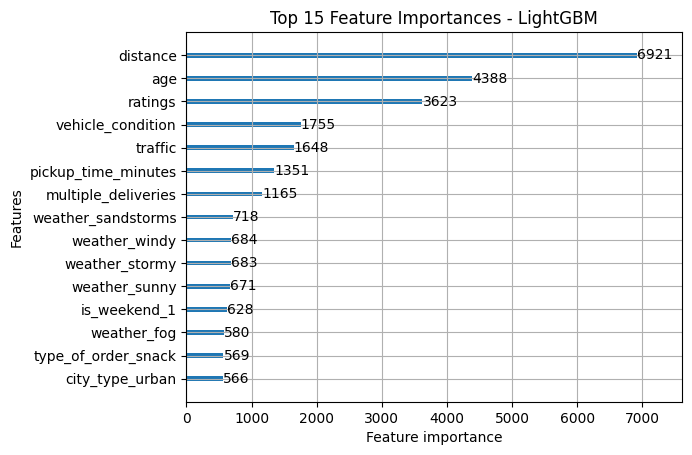

In [21]:
import matplotlib.pyplot as plt
import lightgbm as lgb

lgb.plot_importance(lgb_model, max_num_features=15)
plt.title("Top 15 Feature Importances - LightGBM")
plt.show()

In [156]:
temp_df=dff.copy()

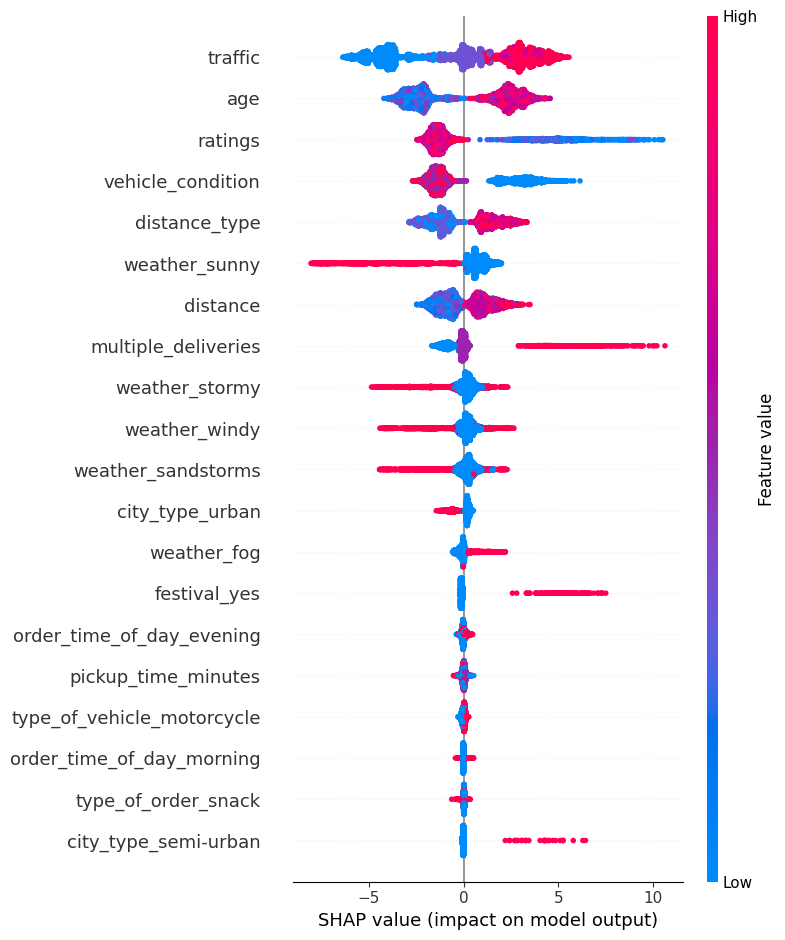

In [22]:
import shap
explainer = shap.Explainer(lgb_model)
shap_values = explainer(X_test_trans)
shap.summary_plot(shap_values, X_test_trans)

In [185]:
temp_df = df.copy().dropna()

In [175]:
temp_df.head()

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,order_day_of_week,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,24,saturday,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,33,friday,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,26,saturday,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21,tuesday,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,30,saturday,1,15.0,afternoon,6.210138,medium


In [182]:
temp_df.columns

Index(['age', 'ratings', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'time_taken', 'is_weekend', 'pickup_time_minutes',
       'order_time_of_day', 'distance', 'distance_type'],
      dtype='object')

In [184]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---------------------------------------------------------
# 1. MAP WEATHER + TRAFFIC
# ---------------------------------------------------------

weather_map = {
    'sunny': 'good', 'clear': 'good', 'cloudy': 'good',
    'windy': 'moderate', 'fog': 'moderate',
    'stormy': 'bad', 'sandstorms': 'bad', 'rainy': 'bad'
}
temp_df["weather_group"] = temp_df["weather"].map(weather_map)

traffic_map = {'low':1, 'medium':2, 'high':3, 'jam':4}
temp_df["traffic_level"] = temp_df["traffic"].map(traffic_map)

# ---------------------------------------------------------
# 2. DROP ORIGINAL UNUSED COLUMNS
# ---------------------------------------------------------
temp_df = temp_df.drop(columns=["weather", "traffic"])

# ---------------------------------------------------------
# 3. Train-test split
# ---------------------------------------------------------
X = temp_df.drop(columns=["time_taken"])
y = temp_df["time_taken"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---------------------------------------------------------
# 4. Identify Feature Types
# ---------------------------------------------------------
num_cols = ["age", "ratings", "pickup_time_minutes", "distance"]

ordinal_cols = ["traffic_level", "distance_type"]

nominal_cols = [
    "weather_group", "type_of_order", "type_of_vehicle",
    "festival", "city_type", "order_time_of_day"
]

binary_cols = ["is_weekend", "multiple_deliveries"]

# Ordinal encoding rules
distance_type_order = ["short","medium","long","very_long"]
ordinal_rules = [
    [1, 2, 3, 4],            # traffic_level
    distance_type_order      # distance_type
]

# ---------------------------------------------------------
# 5. ColumnTransformer
# ---------------------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("scale", MinMaxScaler(), num_cols),
        ("ordinal_encode", OrdinalEncoder(categories=ordinal_rules), ordinal_cols),
        ("nominal_encode",
         OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False),
         nominal_cols)
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)

preprocessor.set_output(transform="pandas")

# ---------------------------------------------------------
# 6. Fit transform
# ---------------------------------------------------------
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# ---------------------------------------------------------
# 7. LightGBM Training
# ---------------------------------------------------------
model = LGBMRegressor(
    random_state=42,
    n_estimators=1000,
    learning_rate=0.03,
    num_leaves=50
)

model.fit(X_train_trans, y_train)

# ---------------------------------------------------------
# 8. Evaluation
# ---------------------------------------------------------
y_pred = model.predict(X_test_trans)

MAE = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)

print("MAE :", MAE)
print("RMSE:", RMSE)
print("R2  :", R2)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 23
[LightGBM] [Info] Start training from score 26.606712
MAE : 3.840815663890125
RMSE: 4.938984707341181
R2  : 0.7210754145518774


# optuna-catboost


In [187]:
import optuna
import mlflow
import mlflow.sklearn
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
import numpy as np
import pandas as pd

# ============================================================
# 1️⃣ TRAIN-TEST SPLIT (using temp_df)
# ============================================================
X = temp_df.drop(columns=["time_taken"])
y = temp_df["time_taken"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============================================================
# 2️⃣ PREPROCESSOR (your final preprocessing code)
# ============================================================
num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = [
    'weather','type_of_order','type_of_vehicle',
    "festival","city_type","is_weekend",
    "order_time_of_day"
]

ordinal_cat_cols = ["traffic","distance_type"]
traffic_order = ["low","medium","high","jam"]
distance_type_order = ["short","medium","long","very_long"]

preprocessor = ColumnTransformer(
    transformers=[
        ("scale", MinMaxScaler(), num_cols),
        ("nominal_encode", OneHotEncoder(drop="first", handle_unknown="ignore",
                                         sparse_output=False), nominal_cat_cols),
        ("ordinal_encode", OrdinalEncoder(categories=[traffic_order, distance_type_order]),
         ordinal_cat_cols)
    ],
    remainder="passthrough",
    n_jobs=-1,
    verbose_feature_names_out=False
)

preprocessor.set_output(transform="pandas")

X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# ============================================================
# 3️⃣ OPTUNA OBJECTIVE FUNCTION
# ============================================================
mlflow.set_tracking_uri("http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000")
mlflow.set_experiment("Exp 3 - CatBoost Optuna Tuning")

def objective(trial):

    # ---- Hyperparameters to optimize ----
    params = {
        "depth": trial.suggest_int("depth", 4, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "iterations": trial.suggest_int("iterations", 500, 3000),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 3.0),
        "random_seed": 42,
        "loss_function": "RMSE",
        "verbose": False
    }

    # ---- MLflow logging per trial ----
    with mlflow.start_run(nested=True):
        mlflow.log_params(params)

        model = CatBoostRegressor(**params)
        model.fit(X_train_trans, y_train)

        preds = model.predict(X_test_trans)

        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)

        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("R2", r2)

    return rmse   # Optuna minimizes RMSE

# ============================================================
# 4️⃣ RUN OPTUNA
# ============================================================
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)

best_params = study.best_trial.params

print("\n===============================")
print("🎉 BEST OPTUNA RESULT")
print("===============================")
print("Best RMSE:", study.best_value)
print("Best Params:", best_params)

# ============================================================
# 5️⃣ TRAIN FINAL BEST MODEL + MLflow LOGGING
# ============================================================
with mlflow.start_run(run_name="CatBoost - Optuna Best Model"):
    mlflow.log_params(best_params)

    best_model = CatBoostRegressor(
        **best_params,
        random_seed=42,
        loss_function="RMSE",
        verbose=False
    )

    best_model.fit(X_train_trans, y_train)
    y_pred = best_model.predict(X_test_trans)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("R2", r2)

    mlflow.sklearn.log_model(best_model, "catboost_best_model")

print("\n✅ Best CatBoost model logged to MLflow!")
print("MAE :", mae)
print("RMSE:", rmse)
print("R2  :", r2)


2025/11/19 14:47:54 INFO mlflow.tracking.fluent: Experiment with name 'Exp 3 - CatBoost Optuna Tuning' does not exist. Creating a new experiment.
[I 2025-11-19 14:47:55,863] A new study created in memory with name: no-name-edabf342-c6dc-4354-a3f0-62fefb6345fc


🏃 View run fun-mouse-640 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/523a0a377cb74c3bac5ed1cc8b2677dc
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 14:49:15,862] Trial 0 finished with value: 4.151910110566247 and parameters: {'depth': 10, 'learning_rate': 0.19276879596174906, 'iterations': 1625, 'l2_leaf_reg': 0.01325968555553159}. Best is trial 0 with value: 4.151910110566247.


🏃 View run caring-cat-667 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/39d39e9fcf444701a31828dfe9901a81
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 14:53:08,459] Trial 1 finished with value: 4.146163851212912 and parameters: {'depth': 11, 'learning_rate': 0.16139326970304047, 'iterations': 2624, 'l2_leaf_reg': 0.6727478359715803}. Best is trial 1 with value: 4.146163851212912.


🏃 View run classy-dolphin-472 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/32bb0618d4d14d41aca7d03f5a803642
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 14:53:34,018] Trial 2 finished with value: 3.879905699279617 and parameters: {'depth': 5, 'learning_rate': 0.1314299519772111, 'iterations': 2800, 'l2_leaf_reg': 0.41734100738053964}. Best is trial 2 with value: 3.879905699279617.


🏃 View run useful-whale-249 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/4f2709683f99494b855b33ee3affd750
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 14:54:54,712] Trial 3 finished with value: 3.960872852731809 and parameters: {'depth': 11, 'learning_rate': 0.09872157276899865, 'iterations': 869, 'l2_leaf_reg': 1.3182643597702433}. Best is trial 2 with value: 3.879905699279617.


🏃 View run luminous-flea-111 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/f17763bde4aa40b39fa06bd841e4cb0d
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 14:58:33,932] Trial 4 finished with value: 3.9658357155730783 and parameters: {'depth': 12, 'learning_rate': 0.072037796088513, 'iterations': 1034, 'l2_leaf_reg': 1.2827381531331405}. Best is trial 2 with value: 3.879905699279617.


🏃 View run melodic-steed-881 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/2e0df3ce09fe43c989dc9c0506510b11
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:02:12,384] Trial 5 finished with value: 4.043274300023864 and parameters: {'depth': 11, 'learning_rate': 0.07729738351129098, 'iterations': 2495, 'l2_leaf_reg': 0.704664289889675}. Best is trial 2 with value: 3.879905699279617.


🏃 View run auspicious-stork-444 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/cbd47a657f884f889df2777db8c62c05
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:02:25,751] Trial 6 finished with value: 3.798616912675661 and parameters: {'depth': 7, 'learning_rate': 0.08713795007605203, 'iterations': 747, 'l2_leaf_reg': 1.0066036391421527}. Best is trial 6 with value: 3.798616912675661.


🏃 View run calm-quail-723 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/02d36ec24d634830af16a325ec1bf528
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:02:44,609] Trial 7 finished with value: 3.865253256426251 and parameters: {'depth': 5, 'learning_rate': 0.019522431004202635, 'iterations': 2011, 'l2_leaf_reg': 2.8044656702025983}. Best is trial 6 with value: 3.798616912675661.


🏃 View run clumsy-whale-984 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/942e068d2d9246d48a8a31d1e1406a23
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:04:03,553] Trial 8 finished with value: 3.803675389794977 and parameters: {'depth': 10, 'learning_rate': 0.021244158148308722, 'iterations': 1784, 'l2_leaf_reg': 1.8979487766747607}. Best is trial 6 with value: 3.798616912675661.


🏃 View run calm-crane-611 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/4e4728f067844d0eafe7d9f5977e9c60
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:08:07,790] Trial 9 finished with value: 4.148940743462517 and parameters: {'depth': 11, 'learning_rate': 0.17866865440217067, 'iterations': 2645, 'l2_leaf_reg': 2.446441170877702}. Best is trial 6 with value: 3.798616912675661.


🏃 View run stylish-skunk-880 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/7a7119e55294438aace0118842dc0786
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:08:19,375] Trial 10 finished with value: 3.7836513448731126 and parameters: {'depth': 7, 'learning_rate': 0.054541650575734874, 'iterations': 662, 'l2_leaf_reg': 1.9011972628081337}. Best is trial 10 with value: 3.7836513448731126.


🏃 View run stately-moth-453 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/39809dd6718c4ee99d19f678cf125dbd
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:08:28,790] Trial 11 finished with value: 3.790680033986947 and parameters: {'depth': 7, 'learning_rate': 0.06036209413405054, 'iterations': 525, 'l2_leaf_reg': 1.866078019483302}. Best is trial 10 with value: 3.7836513448731126.


🏃 View run aged-finch-828 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/0bed608ec6da4dd6a27023511cd24f60
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:08:38,210] Trial 12 finished with value: 3.79508738176024 and parameters: {'depth': 7, 'learning_rate': 0.04819428110394983, 'iterations': 510, 'l2_leaf_reg': 1.8407267102582778}. Best is trial 10 with value: 3.7836513448731126.


🏃 View run gaudy-grouse-750 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/9f61e0f56ac64c1aab62c2fad05fab4f
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:08:58,403] Trial 13 finished with value: 3.7998446607459955 and parameters: {'depth': 8, 'learning_rate': 0.05278333693631795, 'iterations': 1269, 'l2_leaf_reg': 2.0877573823114766}. Best is trial 10 with value: 3.7836513448731126.


🏃 View run illustrious-zebra-45 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/db6d91bbe8b5408b852f3855a7c6ae95
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:09:09,417] Trial 14 finished with value: 3.8063314765793375 and parameters: {'depth': 6, 'learning_rate': 0.12383445435505605, 'iterations': 536, 'l2_leaf_reg': 2.275220493687259}. Best is trial 10 with value: 3.7836513448731126.


🏃 View run unruly-gnat-293 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/067d77114acf4ab19f8e3717b7cfecff
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:09:30,615] Trial 15 finished with value: 3.793584715758632 and parameters: {'depth': 8, 'learning_rate': 0.048615012540696806, 'iterations': 1229, 'l2_leaf_reg': 1.6814643145551584}. Best is trial 10 with value: 3.7836513448731126.


🏃 View run shivering-finch-457 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/10a2d3aeebe344dbb441c74a7436d5d6
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:09:42,932] Trial 16 finished with value: 4.224438782862602 and parameters: {'depth': 4, 'learning_rate': 0.010435474502423062, 'iterations': 1400, 'l2_leaf_reg': 2.9787291378663054}. Best is trial 10 with value: 3.7836513448731126.


🏃 View run calm-dolphin-201 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/fe0139ccb6f345b4b94284f16a30778d
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:10:02,838] Trial 17 finished with value: 3.8114690355900316 and parameters: {'depth': 9, 'learning_rate': 0.06326005978122676, 'iterations': 858, 'l2_leaf_reg': 2.505805606089516}. Best is trial 10 with value: 3.7836513448731126.


🏃 View run intrigued-shrike-921 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/4d5c585855ce4f7389c73d0dbef964c2
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:10:30,607] Trial 18 finished with value: 3.78886424005966 and parameters: {'depth': 7, 'learning_rate': 0.03605137967708881, 'iterations': 2184, 'l2_leaf_reg': 1.4643679975228885}. Best is trial 10 with value: 3.7836513448731126.


🏃 View run bedecked-kit-467 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/6b2abf245ea64ab49063860e7489cd49
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:10:56,509] Trial 19 finished with value: 3.7958799720345175 and parameters: {'depth': 6, 'learning_rate': 0.028250273431541087, 'iterations': 2420, 'l2_leaf_reg': 1.3895707151189964}. Best is trial 10 with value: 3.7836513448731126.


🏃 View run mercurial-whale-235 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/dd4b5a6eb08a4fcd821f236830090455
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:11:39,179] Trial 20 finished with value: 3.8397791699184287 and parameters: {'depth': 9, 'learning_rate': 0.037730412392422384, 'iterations': 2153, 'l2_leaf_reg': 0.9858422904628715}. Best is trial 10 with value: 3.7836513448731126.


🏃 View run spiffy-crow-321 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/7fe85d31be514cf8bfcc096489ed45f8
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:12:05,970] Trial 21 finished with value: 3.893495662181564 and parameters: {'depth': 7, 'learning_rate': 0.11493467502306887, 'iterations': 2225, 'l2_leaf_reg': 1.6690725659163768}. Best is trial 10 with value: 3.7836513448731126.


🏃 View run abundant-shark-592 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/4d89c318416b427e8276d7b195276630
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:12:26,808] Trial 22 finished with value: 3.8322195096619844 and parameters: {'depth': 6, 'learning_rate': 0.09008062222947755, 'iterations': 1776, 'l2_leaf_reg': 2.2303370587957563}. Best is trial 10 with value: 3.7836513448731126.


🏃 View run traveling-trout-800 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/6ce959c1f4fc43ce80cd2b787347e659
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:12:38,718] Trial 23 finished with value: 3.803313279199721 and parameters: {'depth': 7, 'learning_rate': 0.037650416477132256, 'iterations': 631, 'l2_leaf_reg': 1.9952108447675152}. Best is trial 10 with value: 3.7836513448731126.


🏃 View run upbeat-pig-722 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/21c85cfa33654214bfbfc0ffec4df52b
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:12:57,318] Trial 24 finished with value: 3.7996919798753566 and parameters: {'depth': 8, 'learning_rate': 0.06264507421123781, 'iterations': 1075, 'l2_leaf_reg': 1.5281873539587045}. Best is trial 10 with value: 3.7836513448731126.


🏃 View run skillful-goat-801 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/185193d4a2ba4b2ebd46747e8167611d
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:13:21,649] Trial 25 finished with value: 3.8242578805855705 and parameters: {'depth': 5, 'learning_rate': 0.036636234509811634, 'iterations': 2972, 'l2_leaf_reg': 1.6947703867955508}. Best is trial 10 with value: 3.7836513448731126.


🏃 View run receptive-carp-466 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/6230a2b0ee1d484bb769a1ba8f4fd6d0
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:13:45,656] Trial 26 finished with value: 3.8441997827416534 and parameters: {'depth': 8, 'learning_rate': 0.07436007404080758, 'iterations': 1490, 'l2_leaf_reg': 1.1937389089499835}. Best is trial 10 with value: 3.7836513448731126.


🏃 View run bouncy-ram-643 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/4675c4fa180248c0932d464a89a06456
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:14:26,118] Trial 27 finished with value: 4.025292456475848 and parameters: {'depth': 9, 'learning_rate': 0.1472661157091708, 'iterations': 2022, 'l2_leaf_reg': 2.572284761342557}. Best is trial 10 with value: 3.7836513448731126.


🏃 View run stately-mule-280 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/f149a3aa759e41bc8c91823ff3c4f043
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:14:38,036] Trial 28 finished with value: 3.808212116513121 and parameters: {'depth': 6, 'learning_rate': 0.05921322126123753, 'iterations': 738, 'l2_leaf_reg': 2.173798347956253}. Best is trial 10 with value: 3.7836513448731126.


🏃 View run carefree-owl-58 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/0b06e63205284b86ae51b0547199acf6
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:14:52,174] Trial 29 finished with value: 3.9025948774141916 and parameters: {'depth': 4, 'learning_rate': 0.10842538501520431, 'iterations': 1625, 'l2_leaf_reg': 1.5548040172713016}. Best is trial 10 with value: 3.7836513448731126.


🏃 View run sincere-slug-683 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/4f098535e7684480a8aa16070de08fb8
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:15:07,538] Trial 30 finished with value: 3.8040132811077596 and parameters: {'depth': 7, 'learning_rate': 0.08745535543062362, 'iterations': 1001, 'l2_leaf_reg': 0.23300091091554553}. Best is trial 10 with value: 3.7836513448731126.


🏃 View run capricious-loon-300 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/ce5c06f002a547f68b26352e0c074edb
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:15:29,451] Trial 31 finished with value: 3.781972929357967 and parameters: {'depth': 8, 'learning_rate': 0.04595021653632045, 'iterations': 1226, 'l2_leaf_reg': 1.8352452028861796}. Best is trial 31 with value: 3.781972929357967.


🏃 View run agreeable-deer-876 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/b919fc1999f94aed9f8df697d69e2a11
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:15:47,133] Trial 32 finished with value: 3.778415274448947 and parameters: {'depth': 9, 'learning_rate': 0.044086220065778975, 'iterations': 712, 'l2_leaf_reg': 1.8267946325823958}. Best is trial 32 with value: 3.778415274448947.


🏃 View run unruly-perch-265 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/1dd7e41c4e7e461ca9e257365478c754
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:16:15,045] Trial 33 finished with value: 3.78651440743653 and parameters: {'depth': 9, 'learning_rate': 0.029908546088676675, 'iterations': 1225, 'l2_leaf_reg': 1.1337598314253077}. Best is trial 32 with value: 3.778415274448947.


🏃 View run enthused-eel-252 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/3de405ec7d9d4ec0be1698e70bc64425
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:17:13,807] Trial 34 finished with value: 3.7690633931582336 and parameters: {'depth': 10, 'learning_rate': 0.017140806785554075, 'iterations': 1170, 'l2_leaf_reg': 0.968507027672777}. Best is trial 34 with value: 3.7690633931582336.


🏃 View run fun-trout-706 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/c8af44a0546e4131893e611c98be3dd7
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:17:57,880] Trial 35 finished with value: 3.7596921300233284 and parameters: {'depth': 10, 'learning_rate': 0.01100294623477566, 'iterations': 897, 'l2_leaf_reg': 0.6956625922116642}. Best is trial 35 with value: 3.7596921300233284.


🏃 View run respected-loon-99 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/04d834bb04424bd184dd1938a6e4c37b
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:18:42,572] Trial 36 finished with value: 3.763033726456951 and parameters: {'depth': 10, 'learning_rate': 0.010128272444482743, 'iterations': 931, 'l2_leaf_reg': 0.7042298137656466}. Best is trial 35 with value: 3.7596921300233284.


🏃 View run clumsy-duck-714 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/74f4afc656b84be999774da4a5c07a0a
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:19:26,622] Trial 37 finished with value: 3.7659936242633254 and parameters: {'depth': 10, 'learning_rate': 0.01145386455680951, 'iterations': 909, 'l2_leaf_reg': 0.6810046735115443}. Best is trial 35 with value: 3.7596921300233284.


🏃 View run languid-conch-359 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/380245e150c642f3b27d10a942bf859b
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:22:24,137] Trial 38 finished with value: 3.792044945540183 and parameters: {'depth': 12, 'learning_rate': 0.018001984564715072, 'iterations': 905, 'l2_leaf_reg': 0.6039562057591286}. Best is trial 35 with value: 3.7596921300233284.


🏃 View run masked-crab-552 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/f887681f798f43b2adddd3530fc5f51b
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


[I 2025-11-19 15:23:15,206] Trial 39 finished with value: 3.7527017901064372 and parameters: {'depth': 10, 'learning_rate': 0.012690362728359193, 'iterations': 1062, 'l2_leaf_reg': 0.10715589227169486}. Best is trial 39 with value: 3.7527017901064372.



🎉 BEST OPTUNA RESULT
Best RMSE: 3.7527017901064372
Best Params: {'depth': 10, 'learning_rate': 0.012690362728359193, 'iterations': 1062, 'l2_leaf_reg': 0.10715589227169486}


2025/11/19 15:24:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/19 15:24:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run CatBoost - Optuna Best Model at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581/runs/20181fe7e6a24a6dbe041d56f94e3d27
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/976743533315287581


ModuleNotFoundError: No module named 'boto3'

# optuna-lightbgm

In [190]:
import optuna
import mlflow
import mlflow.sklearn
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---------------------------------------------------------
# 🔥 0. Set MLflow experiment for Optuna–LightGBM tuning
# ---------------------------------------------------------
mlflow.set_tracking_uri("http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000")
mlflow.set_experiment("Exp 4 - Optuna LightGBM Tuning")


# ---------------------------------------------------------
# 🔥 1. Preprocess using *your custom preprocessor*
# ---------------------------------------------------------
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans  = preprocessor.transform(X_test)


# ---------------------------------------------------------
# 🔥 2. Define Optuna objective
# ---------------------------------------------------------
def objective(trial):

    # 🔧 Hyperparameter search space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1500),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.07),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 20),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
        "random_state": 42
    }

    # ----------------------------------------------------
    # ⭐ Start MLflow run for EACH Optuna trial
    # ----------------------------------------------------
    with mlflow.start_run(nested=True):

        # Log trial parameters
        mlflow.log_params(params)

        # Train model
        model = LGBMRegressor(**params)
        model.fit(X_train_trans, y_train)

        # Predict
        y_pred = model.predict(X_test_trans)

        # Compute metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae  = mean_absolute_error(y_test, y_pred)
        r2   = r2_score(y_test, y_pred)

        # Log metrics
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("R2", r2)

        return rmse   # Optuna will minimize RMSE


# ---------------------------------------------------------
# 🔥 3. Run Optuna Study
# ---------------------------------------------------------
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

best_params = study.best_trial.params
best_rmse = study.best_value
best_trial = study.best_trial.number


# ---------------------------------------------------------
# 🔥 4. Log BEST RESULT to MLflow (single run)
# ---------------------------------------------------------
with mlflow.start_run(run_name="Best-LightGBM-Optuna"):

    mlflow.log_params(best_params)
    mlflow.log_metric("Best_RMSE", best_rmse)

    # Train final best model
    best_model = LGBMRegressor(**best_params)
    best_model.fit(X_train_trans, y_train)

    y_pred = best_model.predict(X_test_trans)

    mlflow.log_metric("Final_Test_MAE", mean_absolute_error(y_test, y_pred))
    mlflow.log_metric("Final_Test_RMSE", np.sqrt(mean_squared_error(y_test, y_pred)))
    mlflow.log_metric("Final_Test_R2", r2_score(y_test, y_pred))

    mlflow.sklearn.log_model(best_model, "best_lgb_model")


# ---------------------------------------------------------
# 🔥 5. Print summary
# ---------------------------------------------------------
print("\n🎉 OPTUNA LIGHTGBM TUNING COMPLETED 🎉")
print("Best Trial:", best_trial)
print("Best RMSE :", best_rmse)
print("Best Params:")
print(best_params)


2025/11/19 20:10:12 INFO mlflow.tracking.fluent: Experiment with name 'Exp 4 - Optuna LightGBM Tuning' does not exist. Creating a new experiment.
[I 2025-11-19 20:10:29,296] A new study created in memory with name: no-name-610a960f-05b3-4d65-b83f-8086d7f63178
  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
🏃 View run charming-slug-332 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399/runs/1e6841064edb46649a31cf8b4c89b0aa
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399


Best trial: 0. Best value: 3.84799:   2%|▏         | 1/50 [00:06<05:40,  6.95s/it]

[I 2025-11-19 20:10:36,273] Trial 0 finished with value: 3.847994785235927 and parameters: {'n_estimators': 498, 'learning_rate': 0.012288180386520655, 'num_leaves': 108, 'max_depth': 12, 'subsample': 0.9905294555233741, 'colsample_bytree': 0.6513187782999721, 'min_child_samples': 92, 'reg_alpha': 0.31182467398769176, 'reg_lambda': 0.7740505180563091}. Best is trial 0 with value: 3.847994785235927.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
🏃 View run marvelous-owl-668 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399/runs/140080c46a694aeebf0773b75d7b9c16
🧪 View experiment at: http

Best trial: 1. Best value: 3.84112:   4%|▍         | 2/50 [00:15<06:05,  7.61s/it]

[I 2025-11-19 20:10:44,344] Trial 1 finished with value: 3.8411180813132026 and parameters: {'n_estimators': 913, 'learning_rate': 0.055206572021899686, 'num_leaves': 82, 'max_depth': 16, 'subsample': 0.5902220074426201, 'colsample_bytree': 0.7324211021623093, 'min_child_samples': 26, 'reg_alpha': 0.0065946218249153254, 'reg_lambda': 0.2838698538885637}. Best is trial 1 with value: 3.8411180813132026.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

Best trial: 1. Best value: 3.84112:   6%|▌         | 3/50 [00:23<06:16,  8.02s/it]

[I 2025-11-19 20:10:52,858] Trial 2 finished with value: 3.905775415205787 and parameters: {'n_estimators': 728, 'learning_rate': 0.030115361896127762, 'num_leaves': 129, 'max_depth': 5, 'subsample': 0.9914614830462205, 'colsample_bytree': 0.7781639366487051, 'min_child_samples': 94, 'reg_alpha': 0.9564210512895519, 'reg_lambda': 0.5551795859657961}. Best is trial 1 with value: 3.8411180813132026.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
🏃 View run victorious-calf-577 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399/runs/dd18e05ec9d64d03bb6dfc13a1f1c197
🧪 View experiment at: htt

Best trial: 3. Best value: 3.76339:   8%|▊         | 4/50 [00:30<05:46,  7.52s/it]

[I 2025-11-19 20:10:59,618] Trial 3 finished with value: 3.763390634495295 and parameters: {'n_estimators': 717, 'learning_rate': 0.007924818985518212, 'num_leaves': 74, 'max_depth': 16, 'subsample': 0.9485695849549025, 'colsample_bytree': 0.9963461890131016, 'min_child_samples': 90, 'reg_alpha': 0.18069201657333112, 'reg_lambda': 0.9756664156207792}. Best is trial 3 with value: 3.763390634495295.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

Best trial: 3. Best value: 3.76339:  10%|█         | 5/50 [00:37<05:40,  7.57s/it]

[I 2025-11-19 20:11:07,283] Trial 4 finished with value: 3.9226486642060485 and parameters: {'n_estimators': 1131, 'learning_rate': 0.06423584462932373, 'num_leaves': 113, 'max_depth': 13, 'subsample': 0.6536677616993816, 'colsample_bytree': 0.7465524236099472, 'min_child_samples': 22, 'reg_alpha': 0.12512706169268895, 'reg_lambda': 0.8772123291676877}. Best is trial 3 with value: 3.763390634495295.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

Best trial: 3. Best value: 3.76339:  12%|█▏        | 6/50 [00:44<05:17,  7.21s/it]

[I 2025-11-19 20:11:13,779] Trial 5 finished with value: 3.8377490716815315 and parameters: {'n_estimators': 934, 'learning_rate': 0.051446025679727246, 'num_leaves': 65, 'max_depth': 7, 'subsample': 0.6533517036933671, 'colsample_bytree': 0.5201526773272029, 'min_child_samples': 48, 'reg_alpha': 0.536171920042774, 'reg_lambda': 0.5783929692654274}. Best is trial 3 with value: 3.763390634495295.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

Best trial: 3. Best value: 3.76339:  14%|█▍        | 7/50 [00:49<04:36,  6.43s/it]

[I 2025-11-19 20:11:18,602] Trial 6 finished with value: 4.006386775515887 and parameters: {'n_estimators': 847, 'learning_rate': 0.035305935959348965, 'num_leaves': 149, 'max_depth': 4, 'subsample': 0.6899597332094839, 'colsample_bytree': 0.8643392802420667, 'min_child_samples': 84, 'reg_alpha': 0.20354992865656485, 'reg_lambda': 0.8985306038491102}. Best is trial 3 with value: 3.763390634495295.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

Best trial: 3. Best value: 3.76339:  16%|█▌        | 8/50 [00:54<04:18,  6.16s/it]

[I 2025-11-19 20:11:24,198] Trial 7 finished with value: 3.773382755136703 and parameters: {'n_estimators': 491, 'learning_rate': 0.04892298061430856, 'num_leaves': 62, 'max_depth': 10, 'subsample': 0.7931677959534931, 'colsample_bytree': 0.9469913564457564, 'min_child_samples': 88, 'reg_alpha': 0.8003773276348247, 'reg_lambda': 0.7251592501881208}. Best is trial 3 with value: 3.763390634495295.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

Best trial: 3. Best value: 3.76339:  18%|█▊        | 9/50 [01:04<05:00,  7.34s/it]

[I 2025-11-19 20:11:34,112] Trial 8 finished with value: 3.9811865452591375 and parameters: {'n_estimators': 1344, 'learning_rate': 0.0649596393535664, 'num_leaves': 141, 'max_depth': 16, 'subsample': 0.9167747835199682, 'colsample_bytree': 0.5428269270772478, 'min_child_samples': 65, 'reg_alpha': 0.27929486680420257, 'reg_lambda': 0.15881889807389316}. Best is trial 3 with value: 3.763390634495295.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

Best trial: 3. Best value: 3.76339:  20%|██        | 10/50 [01:13<05:12,  7.81s/it]

[I 2025-11-19 20:11:42,992] Trial 9 finished with value: 3.8768630483527544 and parameters: {'n_estimators': 1242, 'learning_rate': 0.038698011662052965, 'num_leaves': 122, 'max_depth': 16, 'subsample': 0.8001481035675884, 'colsample_bytree': 0.5185064349712102, 'min_child_samples': 94, 'reg_alpha': 0.5758174044858756, 'reg_lambda': 0.0680833723379154}. Best is trial 3 with value: 3.763390634495295.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
🏃 View run unequaled-yak-359 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399/runs/15732ac23d78491facd8e38d495c5c2b
🧪 View experiment at: htt

Best trial: 3. Best value: 3.76339:  22%|██▏       | 11/50 [01:17<04:18,  6.64s/it]

[I 2025-11-19 20:11:46,965] Trial 10 finished with value: 4.485555443613625 and parameters: {'n_estimators': 305, 'learning_rate': 0.008500281710360229, 'num_leaves': 20, 'max_depth': 20, 'subsample': 0.8837028052349942, 'colsample_bytree': 0.9818133298004557, 'min_child_samples': 66, 'reg_alpha': 0.42393156094031925, 'reg_lambda': 0.34750965641407716}. Best is trial 3 with value: 3.763390634495295.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

Best trial: 3. Best value: 3.76339:  24%|██▍       | 12/50 [01:22<03:52,  6.11s/it]

[I 2025-11-19 20:11:51,860] Trial 11 finished with value: 3.7764965269305955 and parameters: {'n_estimators': 587, 'learning_rate': 0.02002179679412575, 'num_leaves': 51, 'max_depth': 10, 'subsample': 0.8004233039759595, 'colsample_bytree': 0.979849388226743, 'min_child_samples': 72, 'reg_alpha': 0.7729992819509649, 'reg_lambda': 0.7199749317917582}. Best is trial 3 with value: 3.763390634495295.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

Best trial: 3. Best value: 3.76339:  26%|██▌       | 13/50 [01:26<03:24,  5.54s/it]

[I 2025-11-19 20:11:56,093] Trial 12 finished with value: 3.7769843660813236 and parameters: {'n_estimators': 393, 'learning_rate': 0.046500979649930586, 'num_leaves': 46, 'max_depth': 10, 'subsample': 0.8675112969941043, 'colsample_bytree': 0.9051212949029557, 'min_child_samples': 77, 'reg_alpha': 0.8409571414816153, 'reg_lambda': 0.9491165935911514}. Best is trial 3 with value: 3.763390634495295.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
🏃 View run invincible-conch-813 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399/runs/ad859135ea8d4fa89ff3e3fe13071b26
🧪 View experiment at: h

Best trial: 13. Best value: 3.75083:  28%|██▊       | 14/50 [01:32<03:22,  5.61s/it]

[I 2025-11-19 20:12:01,879] Trial 13 finished with value: 3.750830343962926 and parameters: {'n_estimators': 660, 'learning_rate': 0.02475660308581595, 'num_leaves': 89, 'max_depth': 19, 'subsample': 0.5263660404581432, 'colsample_bytree': 0.8967202036063837, 'min_child_samples': 41, 'reg_alpha': 0.6510811037349641, 'reg_lambda': 0.7126728582827999}. Best is trial 13 with value: 3.750830343962926.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
🏃 View run dazzling-mouse-475 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399/runs/90814d96ff3a4d7191b400815b1cec95
🧪 View experiment at: http

Best trial: 14. Best value: 3.7488:  30%|███       | 15/50 [01:38<03:23,  5.82s/it] 

[I 2025-11-19 20:12:08,170] Trial 14 finished with value: 3.7488030652189166 and parameters: {'n_estimators': 704, 'learning_rate': 0.020119881386167666, 'num_leaves': 92, 'max_depth': 20, 'subsample': 0.5764373349368237, 'colsample_bytree': 0.842814535624884, 'min_child_samples': 39, 'reg_alpha': 0.6467910277034379, 'reg_lambda': 0.9860039782466411}. Best is trial 14 with value: 3.7488030652189166.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
🏃 View run industrious-roo-558 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399/runs/7ccec94ce11b4de288e4d9fcbae9208c
🧪 View experiment at: h

Best trial: 14. Best value: 3.7488:  32%|███▏      | 16/50 [01:44<03:19,  5.85s/it]

[I 2025-11-19 20:12:14,109] Trial 15 finished with value: 3.7530908305359327 and parameters: {'n_estimators': 642, 'learning_rate': 0.02258368846311725, 'num_leaves': 97, 'max_depth': 20, 'subsample': 0.5194016990859783, 'colsample_bytree': 0.8349353840953497, 'min_child_samples': 40, 'reg_alpha': 0.6574830628039874, 'reg_lambda': 0.4347246436248903}. Best is trial 14 with value: 3.7488030652189166.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
🏃 View run mysterious-wolf-585 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399/runs/38e32af6932d436894c021f28be5adae
🧪 View experiment at: h

Best trial: 14. Best value: 3.7488:  34%|███▍      | 17/50 [01:51<03:22,  6.15s/it]

[I 2025-11-19 20:12:20,931] Trial 16 finished with value: 3.7564431088419377 and parameters: {'n_estimators': 1047, 'learning_rate': 0.02083880458939415, 'num_leaves': 95, 'max_depth': 18, 'subsample': 0.5234866387087186, 'colsample_bytree': 0.8205434590471714, 'min_child_samples': 8, 'reg_alpha': 0.6709297862724661, 'reg_lambda': 0.6418917011195739}. Best is trial 14 with value: 3.7488030652189166.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
🏃 View run bustling-bass-346 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399/runs/b60594c4cac048408a0f175722f0c403
🧪 View experiment at: htt

Best trial: 14. Best value: 3.7488:  36%|███▌      | 18/50 [01:59<03:37,  6.80s/it]

[I 2025-11-19 20:12:29,263] Trial 17 finished with value: 3.828254284031198 and parameters: {'n_estimators': 1481, 'learning_rate': 0.026955843264094996, 'num_leaves': 91, 'max_depth': 19, 'subsample': 0.6194719636800744, 'colsample_bytree': 0.9068518636214296, 'min_child_samples': 36, 'reg_alpha': 0.449915522022174, 'reg_lambda': 0.8208315019615963}. Best is trial 14 with value: 3.7488030652189166.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
🏃 View run burly-robin-982 at: http://ec2

Best trial: 14. Best value: 3.7488:  38%|███▊      | 19/50 [02:06<03:28,  6.72s/it]

[I 2025-11-19 20:12:35,797] Trial 18 finished with value: 3.764184890991264 and parameters: {'n_estimators': 791, 'learning_rate': 0.014257409541760347, 'num_leaves': 105, 'max_depth': 18, 'subsample': 0.565105965506531, 'colsample_bytree': 0.6945637693375262, 'min_child_samples': 53, 'reg_alpha': 0.6585136753710431, 'reg_lambda': 0.6568214234362173}. Best is trial 14 with value: 3.7488030652189166.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

Best trial: 14. Best value: 3.7488:  40%|████      | 20/50 [02:12<03:16,  6.56s/it]

[I 2025-11-19 20:12:41,968] Trial 19 finished with value: 3.808427878201862 and parameters: {'n_estimators': 1012, 'learning_rate': 0.03800829208154351, 'num_leaves': 78, 'max_depth': 14, 'subsample': 0.7172038571220473, 'colsample_bytree': 0.8925726610642241, 'min_child_samples': 56, 'reg_alpha': 0.9310743339677974, 'reg_lambda': 0.9839406417542645}. Best is trial 14 with value: 3.7488030652189166.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
🏃 View run popular-fox-177 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399/runs/de9c369d16454f02ab063d7df9242594
🧪 View experiment at: http:

Best trial: 14. Best value: 3.7488:  42%|████▏     | 21/50 [02:16<02:48,  5.82s/it]

[I 2025-11-19 20:12:46,062] Trial 20 finished with value: 3.8409069743670314 and parameters: {'n_estimators': 549, 'learning_rate': 0.030472818610342543, 'num_leaves': 28, 'max_depth': 18, 'subsample': 0.5584150159258748, 'colsample_bytree': 0.8100189410077397, 'min_child_samples': 29, 'reg_alpha': 0.36917219346760066, 'reg_lambda': 0.8299802460464885}. Best is trial 14 with value: 3.7488030652189166.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
🏃 View run painted-hog-119 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399/runs/2a17750a9e5042408dc07835b55b64e1
🧪 View experiment at: htt

Best trial: 21. Best value: 3.74752:  44%|████▍     | 22/50 [02:22<02:41,  5.77s/it]

[I 2025-11-19 20:12:51,722] Trial 21 finished with value: 3.7475227881221684 and parameters: {'n_estimators': 649, 'learning_rate': 0.019934358565073834, 'num_leaves': 96, 'max_depth': 20, 'subsample': 0.508281116835944, 'colsample_bytree': 0.8490707320437081, 'min_child_samples': 42, 'reg_alpha': 0.6583878313066953, 'reg_lambda': 0.44002315807755776}. Best is trial 21 with value: 3.7475227881221684.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
🏃 View run clean-yak-642 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399/runs/c04f7a6bbc8340c2ae92aa09a967d1f8
🧪 View experiment at: http:/

Best trial: 21. Best value: 3.74752:  46%|████▌     | 23/50 [02:28<02:37,  5.85s/it]

[I 2025-11-19 20:12:57,753] Trial 22 finished with value: 3.7479859548239793 and parameters: {'n_estimators': 733, 'learning_rate': 0.01625288466824752, 'num_leaves': 87, 'max_depth': 20, 'subsample': 0.5067828500582712, 'colsample_bytree': 0.9312742606225046, 'min_child_samples': 43, 'reg_alpha': 0.7283489732975432, 'reg_lambda': 0.4585515747126056}. Best is trial 21 with value: 3.7475227881221684.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
🏃 View run mercurial-jay-55 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399/runs/668a2d31dcdf4a3e921702311bc2392f
🧪 View experiment at: http

Best trial: 21. Best value: 3.74752:  48%|████▊     | 24/50 [02:34<02:37,  6.06s/it]

[I 2025-11-19 20:13:04,313] Trial 23 finished with value: 3.7499857177973475 and parameters: {'n_estimators': 798, 'learning_rate': 0.016441519334981707, 'num_leaves': 120, 'max_depth': 20, 'subsample': 0.5996026037055359, 'colsample_bytree': 0.9349726096078719, 'min_child_samples': 11, 'reg_alpha': 0.7322025740808269, 'reg_lambda': 0.46358825473932364}. Best is trial 21 with value: 3.7475227881221684.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
🏃 View run intelligent-swan-560 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399/runs/78b2340bdfe64b5f9f96fb1af7d6d604
🧪 View experiment a

Best trial: 21. Best value: 3.74752:  50%|█████     | 25/50 [02:39<02:21,  5.67s/it]

[I 2025-11-19 20:13:09,053] Trial 24 finished with value: 3.7705738448553068 and parameters: {'n_estimators': 399, 'learning_rate': 0.01740249143388099, 'num_leaves': 69, 'max_depth': 17, 'subsample': 0.5012276271622575, 'colsample_bytree': 0.8584717018116794, 'min_child_samples': 47, 'reg_alpha': 0.8545506741338201, 'reg_lambda': 0.3569390360603406}. Best is trial 21 with value: 3.7475227881221684.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
🏃 View run youthful-loon-957 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399/runs/b5b37b3b844e4a15935e8ac71329a4ed
🧪 View experiment at: htt

Best trial: 21. Best value: 3.74752:  52%|█████▏    | 26/50 [02:46<02:21,  5.88s/it]

[I 2025-11-19 20:13:15,443] Trial 25 finished with value: 3.7787973830880377 and parameters: {'n_estimators': 698, 'learning_rate': 0.006963723764211558, 'num_leaves': 104, 'max_depth': 14, 'subsample': 0.5557393687274217, 'colsample_bytree': 0.7847367054247867, 'min_child_samples': 33, 'reg_alpha': 0.5441167772251089, 'reg_lambda': 0.21253518078279227}. Best is trial 21 with value: 3.7475227881221684.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
🏃 View run invincible-mare-146 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399/runs/240ab8e018e346d0ac342d74e86dd4e6
🧪 View experiment at

Best trial: 21. Best value: 3.74752:  54%|█████▍    | 27/50 [02:52<02:16,  5.95s/it]

[I 2025-11-19 20:13:21,533] Trial 26 finished with value: 3.7534161966977306 and parameters: {'n_estimators': 799, 'learning_rate': 0.012567199821077676, 'num_leaves': 83, 'max_depth': 20, 'subsample': 0.6237739085841212, 'colsample_bytree': 0.8522938094245358, 'min_child_samples': 57, 'reg_alpha': 0.5945100392798564, 'reg_lambda': 0.5184294267466715}. Best is trial 21 with value: 3.7475227881221684.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
🏃 View run peaceful-lynx-500 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399/runs/f8a0fe0643ed43e3be75420f8913bcfd
🧪 View experiment at: ht

Best trial: 21. Best value: 3.74752:  56%|█████▌    | 28/50 [02:57<02:06,  5.76s/it]

[I 2025-11-19 20:13:26,845] Trial 27 finished with value: 3.7519137018679043 and parameters: {'n_estimators': 605, 'learning_rate': 0.031539424569690916, 'num_leaves': 96, 'max_depth': 18, 'subsample': 0.5621642303415301, 'colsample_bytree': 0.9420682651143745, 'min_child_samples': 18, 'reg_alpha': 0.4683569723575578, 'reg_lambda': 0.4036805053831726}. Best is trial 21 with value: 3.7475227881221684.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
🏃 View run big-seal-20 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399/runs/27d58e0db67845d2a2f29d69224fe625
🧪 View experiment at: http://e

Best trial: 21. Best value: 3.74752:  58%|█████▊    | 29/50 [03:02<01:53,  5.39s/it]

[I 2025-11-19 20:13:31,393] Trial 28 finished with value: 3.803047909053262 and parameters: {'n_estimators': 478, 'learning_rate': 0.024599363779891886, 'num_leaves': 50, 'max_depth': 15, 'subsample': 0.6577871960703013, 'colsample_bytree': 0.6697999609645753, 'min_child_samples': 45, 'reg_alpha': 0.722027135732652, 'reg_lambda': 0.2896322002976972}. Best is trial 21 with value: 3.7475227881221684.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

Best trial: 21. Best value: 3.74752:  60%|██████    | 30/50 [03:09<01:58,  5.91s/it]

[I 2025-11-19 20:13:38,514] Trial 29 finished with value: 3.7486800949948385 and parameters: {'n_estimators': 955, 'learning_rate': 0.010917414143351362, 'num_leaves': 112, 'max_depth': 12, 'subsample': 0.5032052575264433, 'colsample_bytree': 0.7892252229214997, 'min_child_samples': 61, 'reg_alpha': 0.8843570146753392, 'reg_lambda': 0.49250971766938006}. Best is trial 21 with value: 3.7475227881221684.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

Best trial: 21. Best value: 3.74752:  62%|██████▏   | 31/50 [03:16<02:01,  6.37s/it]

[I 2025-11-19 20:13:45,949] Trial 30 finished with value: 3.8020726820334705 and parameters: {'n_estimators': 988, 'learning_rate': 0.011048697801911879, 'num_leaves': 112, 'max_depth': 12, 'subsample': 0.5103427675627775, 'colsample_bytree': 0.6041378312162912, 'min_child_samples': 61, 'reg_alpha': 0.8800029742621048, 'reg_lambda': 0.5980962449801794}. Best is trial 21 with value: 3.7475227881221684.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
🏃 View run secretive-kite-316 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399/runs/6c245c2ba1fe4a78ab95778a135910b3
🧪 View experiment at: 

Best trial: 21. Best value: 3.74752:  64%|██████▍   | 32/50 [03:24<02:01,  6.75s/it]

[I 2025-11-19 20:13:53,579] Trial 31 finished with value: 3.7902561365712146 and parameters: {'n_estimators': 874, 'learning_rate': 0.005288789764311047, 'num_leaves': 127, 'max_depth': 11, 'subsample': 0.5450530298756154, 'colsample_bytree': 0.7812624984608466, 'min_child_samples': 49, 'reg_alpha': 0.9983278476503923, 'reg_lambda': 0.49161787006889446}. Best is trial 21 with value: 3.7475227881221684.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
🏃 View run awesome-rook-463 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399/runs/08a6a8e7794946de87b30e9fa986dd0f
🧪 View experiment at: h

Best trial: 21. Best value: 3.74752:  66%|██████▌   | 33/50 [03:30<01:52,  6.64s/it]

[I 2025-11-19 20:13:59,977] Trial 32 finished with value: 3.7630505960699456 and parameters: {'n_estimators': 748, 'learning_rate': 0.017307829756186294, 'num_leaves': 103, 'max_depth': 19, 'subsample': 0.5849639306816882, 'colsample_bytree': 0.7062279771953336, 'min_child_samples': 35, 'reg_alpha': 0.7484196690658163, 'reg_lambda': 0.38334885434942634}. Best is trial 21 with value: 3.7475227881221684.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

Best trial: 21. Best value: 3.74752:  68%|██████▊   | 34/50 [03:37<01:46,  6.66s/it]

[I 2025-11-19 20:14:06,665] Trial 33 finished with value: 3.779970031026667 and parameters: {'n_estimators': 1096, 'learning_rate': 0.012245712425996097, 'num_leaves': 86, 'max_depth': 8, 'subsample': 0.5037028235445274, 'colsample_bytree': 0.8053905443468965, 'min_child_samples': 28, 'reg_alpha': 0.9037846583604598, 'reg_lambda': 0.28061945414285316}. Best is trial 21 with value: 3.7475227881221684.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

Best trial: 21. Best value: 3.74752:  70%|███████   | 35/50 [03:44<01:41,  6.79s/it]

[I 2025-11-19 20:14:13,751] Trial 34 finished with value: 3.784006004243982 and parameters: {'n_estimators': 938, 'learning_rate': 0.019739393272797296, 'num_leaves': 117, 'max_depth': 17, 'subsample': 0.5906051876361955, 'colsample_bytree': 0.7498230869657369, 'min_child_samples': 42, 'reg_alpha': 0.8105175424268565, 'reg_lambda': 0.5317677580587723}. Best is trial 21 with value: 3.7475227881221684.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

Best trial: 21. Best value: 3.74752:  72%|███████▏  | 36/50 [03:52<01:41,  7.28s/it]

[I 2025-11-19 20:14:22,199] Trial 35 finished with value: 3.808718147221007 and parameters: {'n_estimators': 1194, 'learning_rate': 0.02739618058122504, 'num_leaves': 131, 'max_depth': 13, 'subsample': 0.5388229933703538, 'colsample_bytree': 0.8764071447814303, 'min_child_samples': 19, 'reg_alpha': 0.7166550913107215, 'reg_lambda': 0.4714128965184713}. Best is trial 21 with value: 3.7475227881221684.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
🏃 View run beautiful-deer-28 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399/runs/53cfd55431644c76b8a4d583b1f36095
🧪 View experiment at: ht

Best trial: 21. Best value: 3.74752:  74%|███████▍  | 37/50 [03:59<01:31,  7.04s/it]

[I 2025-11-19 20:14:28,677] Trial 36 finished with value: 3.760094698072453 and parameters: {'n_estimators': 901, 'learning_rate': 0.009834094220796199, 'num_leaves': 77, 'max_depth': 17, 'subsample': 0.6142595771653852, 'colsample_bytree': 0.7287041263104354, 'min_child_samples': 52, 'reg_alpha': 0.6166112641263612, 'reg_lambda': 0.2971160737788181}. Best is trial 21 with value: 3.7475227881221684.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

Best trial: 37. Best value: 3.74467:  76%|███████▌  | 38/50 [04:05<01:22,  6.84s/it]

[I 2025-11-19 20:14:35,042] Trial 37 finished with value: 3.7446723688409165 and parameters: {'n_estimators': 731, 'learning_rate': 0.014850959317240326, 'num_leaves': 100, 'max_depth': 15, 'subsample': 0.575426956719928, 'colsample_bytree': 0.8372839934225397, 'min_child_samples': 60, 'reg_alpha': 0.5201348791725293, 'reg_lambda': 0.609484465536558}. Best is trial 37 with value: 3.7446723688409165.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

Best trial: 37. Best value: 3.74467:  78%|███████▊  | 39/50 [04:12<01:15,  6.85s/it]

[I 2025-11-19 20:14:41,917] Trial 38 finished with value: 3.75558077951697 and parameters: {'n_estimators': 838, 'learning_rate': 0.014089390156841203, 'num_leaves': 107, 'max_depth': 13, 'subsample': 0.6442277135663841, 'colsample_bytree': 0.7689160081596116, 'min_child_samples': 73, 'reg_alpha': 0.4999336353935069, 'reg_lambda': 0.6256756610300268}. Best is trial 37 with value: 3.7446723688409165.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

Best trial: 37. Best value: 3.74467:  80%|████████  | 40/50 [04:18<01:04,  6.47s/it]

[I 2025-11-19 20:14:47,502] Trial 39 finished with value: 3.7789037767499383 and parameters: {'n_estimators': 537, 'learning_rate': 0.01554241822635654, 'num_leaves': 112, 'max_depth': 11, 'subsample': 0.7492379968768367, 'colsample_bytree': 0.9173521667032635, 'min_child_samples': 99, 'reg_alpha': 0.5299112238320405, 'reg_lambda': 0.5804868886388797}. Best is trial 37 with value: 3.7446723688409165.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

Best trial: 37. Best value: 3.74467:  82%|████████▏ | 41/50 [04:23<00:54,  6.08s/it]

[I 2025-11-19 20:14:52,677] Trial 40 finished with value: 3.818255467251868 and parameters: {'n_estimators': 759, 'learning_rate': 0.059906284549943706, 'num_leaves': 101, 'max_depth': 8, 'subsample': 0.6818126549779246, 'colsample_bytree': 0.881326197593799, 'min_child_samples': 63, 'reg_alpha': 0.37651564721643715, 'reg_lambda': 0.42603195486076606}. Best is trial 37 with value: 3.7446723688409165.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

Best trial: 37. Best value: 3.74467:  84%|████████▍ | 42/50 [04:29<00:48,  6.01s/it]

[I 2025-11-19 20:14:58,514] Trial 41 finished with value: 3.7743956757848967 and parameters: {'n_estimators': 677, 'learning_rate': 0.03406009291941228, 'num_leaves': 90, 'max_depth': 15, 'subsample': 0.5713189010453876, 'colsample_bytree': 0.8412459720226696, 'min_child_samples': 58, 'reg_alpha': 0.7003211279285537, 'reg_lambda': 0.5201505994042487}. Best is trial 37 with value: 3.7446723688409165.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
🏃 View run delicate-snipe-41 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399/runs/0ff7ec3f710148a88f73c1a51e711d36
🧪 View experiment at: htt

Best trial: 37. Best value: 3.74467:  86%|████████▌ | 43/50 [04:35<00:41,  5.96s/it]

[I 2025-11-19 20:15:04,373] Trial 42 finished with value: 3.776149768974177 and parameters: {'n_estimators': 727, 'learning_rate': 0.008958809278197819, 'num_leaves': 72, 'max_depth': 19, 'subsample': 0.5361974286650361, 'colsample_bytree': 0.7999722346864014, 'min_child_samples': 52, 'reg_alpha': 0.5948779396811205, 'reg_lambda': 0.7817321113338922}. Best is trial 37 with value: 3.7446723688409165.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
🏃 View run righteous-yak-103 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/7882456

Best trial: 37. Best value: 3.74467:  88%|████████▊ | 44/50 [04:40<00:35,  5.87s/it]

[I 2025-11-19 20:15:10,034] Trial 43 finished with value: 3.7561397103481493 and parameters: {'n_estimators': 617, 'learning_rate': 0.0223695479004114, 'num_leaves': 82, 'max_depth': 20, 'subsample': 0.5015415960873222, 'colsample_bytree': 0.8482029000093343, 'min_child_samples': 68, 'reg_alpha': 0.03299251257689284, 'reg_lambda': 0.1516427848519878}. Best is trial 37 with value: 3.7446723688409165.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
🏃 View run rare-hen-366 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399/runs/1f5f5307b6b14ee59a4947191e692809
🧪 View experiment at: http://e

Best trial: 37. Best value: 3.74467:  90%|█████████ | 45/50 [04:46<00:29,  5.84s/it]

[I 2025-11-19 20:15:15,805] Trial 44 finished with value: 3.7562201291228705 and parameters: {'n_estimators': 934, 'learning_rate': 0.018419951630353114, 'num_leaves': 59, 'max_depth': 15, 'subsample': 0.5765664225356122, 'colsample_bytree': 0.957854965128881, 'min_child_samples': 38, 'reg_alpha': 0.7933325290500931, 'reg_lambda': 0.33330374947163177}. Best is trial 37 with value: 3.7446723688409165.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

Best trial: 37. Best value: 3.74467:  92%|█████████▏| 46/50 [04:51<00:22,  5.59s/it]

[I 2025-11-19 20:15:20,804] Trial 45 finished with value: 3.838096104789441 and parameters: {'n_estimators': 855, 'learning_rate': 0.02707702779364613, 'num_leaves': 98, 'max_depth': 6, 'subsample': 0.5374858402786292, 'colsample_bytree': 0.8277900356272192, 'min_child_samples': 81, 'reg_alpha': 0.5516855813846124, 'reg_lambda': 0.013545966008924548}. Best is trial 37 with value: 3.7446723688409165.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
🏃 View run bedecked-kite-768 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399/runs/7ccd9b136ac14dc4bebd469fa89be8d6
🧪 View experiment at: htt

Best trial: 37. Best value: 3.74467:  94%|█████████▍| 47/50 [04:58<00:17,  5.89s/it]

[I 2025-11-19 20:15:27,384] Trial 46 finished with value: 3.756311424247967 and parameters: {'n_estimators': 703, 'learning_rate': 0.011370475783324487, 'num_leaves': 111, 'max_depth': 16, 'subsample': 0.60045571219059, 'colsample_bytree': 0.7618338695635393, 'min_child_samples': 44, 'reg_alpha': 0.618007653963931, 'reg_lambda': 0.9172183794916153}. Best is trial 37 with value: 3.7446723688409165.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
🏃 View run wistful-rat-691 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399/runs/662e4b0f08544d869b188967e7bd50e3
🧪 View experiment at: http://

Best trial: 37. Best value: 3.74467:  96%|█████████▌| 48/50 [05:03<00:11,  5.87s/it]

[I 2025-11-19 20:15:33,213] Trial 47 finished with value: 3.745281614651963 and parameters: {'n_estimators': 458, 'learning_rate': 0.023261261104109247, 'num_leaves': 126, 'max_depth': 19, 'subsample': 0.9621012968164828, 'colsample_bytree': 0.8748823516072564, 'min_child_samples': 24, 'reg_alpha': 0.8342565273897015, 'reg_lambda': 0.4469278052184267}. Best is trial 37 with value: 3.7446723688409165.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
🏃 View run carefree-mole-164 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245

Best trial: 37. Best value: 3.74467:  98%|█████████▊| 49/50 [05:09<00:05,  5.75s/it]

[I 2025-11-19 20:15:38,669] Trial 48 finished with value: 3.7891190488306834 and parameters: {'n_estimators': 408, 'learning_rate': 0.04581441899568264, 'num_leaves': 139, 'max_depth': 17, 'subsample': 0.9474942197520917, 'colsample_bytree': 0.9167447885706073, 'min_child_samples': 24, 'reg_alpha': 0.9697019284384202, 'reg_lambda': 0.5502706714233186}. Best is trial 37 with value: 3.7446723688409165.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
🏃 View run gifted-shark-183 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399/runs/779d7d4b6c3e475aab0731e8cafdc03b
🧪 View experiment at: htt

Best trial: 37. Best value: 3.74467: 100%|██████████| 50/50 [05:15<00:00,  6.30s/it]


[I 2025-11-19 20:15:44,357] Trial 49 finished with value: 3.7628953208920004 and parameters: {'n_estimators': 457, 'learning_rate': 0.02389970109424728, 'num_leaves': 137, 'max_depth': 19, 'subsample': 0.9927679789248194, 'colsample_bytree': 0.9670766080266614, 'min_child_samples': 30, 'reg_alpha': 0.8288302446709515, 'reg_lambda': 0.6839030827408747}. Best is trial 37 with value: 3.7446723688409165.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

2025/11/19 20:15:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/19 20:16:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Best-LightGBM-Optuna at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399/runs/3f275718427648bbbfc13e2550e0ba9b
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/788245674740947399

🎉 OPTUNA LIGHTGBM TUNING COMPLETED 🎉
Best Trial: 37
Best RMSE : 3.7446723688409165
Best Params:
{'n_estimators': 731, 'learning_rate': 0.014850959317240326, 'num_leaves': 100, 'max_depth': 15, 'subsample': 0.575426956719928, 'colsample_bytree': 0.8372839934225397, 'min_child_samples': 60, 'reg_alpha': 0.5201348791725293, 'reg_lambda': 0.609484465536558}


# stacking model

In [191]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import optuna
import mlflow
import mlflow.sklearn


In [192]:
num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = [
    'weather','type_of_order','type_of_vehicle',"festival",
    "city_type","is_weekend","order_time_of_day"
]

ordinal_cat_cols = ["traffic","distance_type"]

traffic_order = ["low","medium","high","jam"]
distance_type_order = ["short","medium","long","very_long"]

preprocessor = ColumnTransformer(
    transformers=[
        ("scale", MinMaxScaler(), num_cols),
        ("nominal_encode", OneHotEncoder(drop="first",
                                         handle_unknown="ignore",
                                         sparse_output=False),
         nominal_cat_cols),
        ("ordinal_encode", OrdinalEncoder(
            categories=[traffic_order, distance_type_order]),
         ordinal_cat_cols)
    ],
    remainder="passthrough",
    n_jobs=-1,
    verbose_feature_names_out=False
)

preprocessor.set_output(transform="pandas")


,transformers,"[('scale', ...), ('nominal_encode', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,feature_range,"(0, ...)"
,copy,True
,clip,False


In [193]:
X = temp_df.drop(columns=["time_taken"])
y = temp_df["time_taken"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)


In [194]:
best_lgb_params = {
    "n_estimators": 822,
    "learning_rate": 0.01154017946,
    "num_leaves": 86,
    "max_depth": 14,
    "subsample": 0.6301623646,
    "colsample_bytree": 0.9533450357,
    "min_child_samples": 50,
    "reg_alpha": 0.8141530760,
    "reg_lambda": 0.2535446968,
    "random_state": 42,
}

best_cat_params = {
    "depth": 10,
    "iterations": 1062,
    "learning_rate": 0.0126903627,
    "l2_leaf_reg": 0.1071558923,
    "loss_function": "RMSE",
    "random_seed": 42,
    "verbose": False
}


In [195]:
lgb_model = LGBMRegressor(**best_lgb_params)
cat_model = CatBoostRegressor(**best_cat_params)

lgb_model.fit(X_train_trans, y_train)
cat_model.fit(X_train_trans, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [196]:
train_stack = pd.DataFrame({
    "lgb_pred": lgb_model.predict(X_train_trans),
    "cat_pred": cat_model.predict(X_train_trans)
})

test_stack = pd.DataFrame({
    "lgb_pred": lgb_model.predict(X_test_trans),
    "cat_pred": cat_model.predict(X_test_trans)
})


In [197]:
mlflow.set_tracking_uri("http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000")
mlflow.set_experiment("Exp 5 - Stacking Meta-Learner Search")

def objective(trial):

    meta_model_type = trial.suggest_categorical(
        "meta_model", ["linear", "ridge", "rf", "lgbm", "cat"]
    )

    if meta_model_type == "linear":
        model = LinearRegression()

    elif meta_model_type == "ridge":
        alpha = trial.suggest_float("ridge_alpha", 0.01, 10)
        model = Ridge(alpha=alpha)

    elif meta_model_type == "rf":
        model = RandomForestRegressor(
            n_estimators=trial.suggest_int("rf_estimators", 200, 800),
            max_depth=trial.suggest_int("rf_depth", 4, 20),
            random_state=42
        )

    elif meta_model_type == "lgbm":
        model = LGBMRegressor(
            n_estimators=trial.suggest_int("lgbm_estimators", 300, 800),
            learning_rate=trial.suggest_float("lgbm_lr", 0.005, 0.05),
            max_depth=trial.suggest_int("lgbm_depth", 3, 12),
            num_leaves=trial.suggest_int("lgbm_leaves", 20, 80),
            random_state=42
        )

    else:
        model = CatBoostRegressor(
            depth=trial.suggest_int("cat_depth", 4, 10),
            learning_rate=trial.suggest_float("cat_lr", 0.005, 0.05),
            iterations=trial.suggest_int("cat_iters", 300, 800),
            loss_function="RMSE",
            verbose=False,
            random_seed=42
        )

    model.fit(train_stack, y_train)
    pred = model.predict(test_stack)

    rmse = np.sqrt(mean_squared_error(y_test, pred))

    # MLflow logging
    with mlflow.start_run(nested=True):
        mlflow.log_params(trial.params)
        mlflow.log_metric("rmse", rmse)

    return rmse


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)


2025/11/20 14:21:28 INFO mlflow.tracking.fluent: Experiment with name 'Exp 5 - Stacking Meta-Learner Search' does not exist. Creating a new experiment.
[I 2025-11-20 14:21:28,958] A new study created in memory with name: no-name-60e3d60b-e603-401d-969b-15c0e83a845f


🏃 View run gaudy-gnu-831 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/1d451bde40ef45128015ffcd8968d885
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:21:31,569] Trial 0 finished with value: 3.8387343600625803 and parameters: {'meta_model': 'linear'}. Best is trial 0 with value: 3.8387343600625803.


🏃 View run adventurous-moth-737 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/e554cbcb417c44599080940953a7a2b8
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:21:33,872] Trial 1 finished with value: 3.83854023547587 and parameters: {'meta_model': 'ridge', 'ridge_alpha': 8.210695994603448}. Best is trial 1 with value: 3.83854023547587.


🏃 View run loud-doe-906 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/eaccd2b00b7644bfb5f754506446e80f
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:21:36,132] Trial 2 finished with value: 3.8387043370881577 and parameters: {'meta_model': 'ridge', 'ridge_alpha': 1.2684029468522575}. Best is trial 1 with value: 3.83854023547587.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 2
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
🏃 View run crawling-foal-198 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/2fa2a23f85014be99748565a6f41aaaa
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:21:39,752] Trial 3 finished with value: 3.8905310582937624 and parameters: {'meta_model': 'lgbm', 'lgbm_estimators': 561, 'lgbm_lr': 0.009409995251666164, 'lgbm_depth': 8, 'lgbm_leaves': 63}. Best is trial 1 with value: 3.83854023547587.


🏃 View run clean-ape-72 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/09315fd223be46858be1b1cfa5f73b66
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:22:08,758] Trial 4 finished with value: 3.8139736474662143 and parameters: {'meta_model': 'cat', 'cat_depth': 10, 'cat_lr': 0.014893550398562702, 'cat_iters': 562}. Best is trial 4 with value: 3.8139736474662143.


🏃 View run luxuriant-croc-544 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/cdf32c86ee634f69a784a253aa1851a0
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:22:39,287] Trial 5 finished with value: 3.7846747157484915 and parameters: {'meta_model': 'cat', 'cat_depth': 10, 'cat_lr': 0.008585159716414905, 'cat_iters': 565}. Best is trial 5 with value: 3.7846747157484915.


🏃 View run placid-ox-171 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/a0b4fc2ac9ba46e29b92f87c48e8ee27
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:22:44,643] Trial 6 finished with value: 3.8186959861781262 and parameters: {'meta_model': 'cat', 'cat_depth': 4, 'cat_lr': 0.042909044596484744, 'cat_iters': 402}. Best is trial 5 with value: 3.7846747157484915.


🏃 View run thundering-duck-365 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/1df7f88cbf234fbabe8529e2c1eb0836
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:22:48,103] Trial 7 finished with value: 3.8385453350801475 and parameters: {'meta_model': 'ridge', 'ridge_alpha': 7.994719185847222}. Best is trial 5 with value: 3.7846747157484915.


🏃 View run trusting-lynx-154 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/9c16e7c301a848c0bc1600be3874d070
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:22:52,864] Trial 8 finished with value: 3.8201727108128143 and parameters: {'meta_model': 'cat', 'cat_depth': 5, 'cat_lr': 0.045750503651715915, 'cat_iters': 337}. Best is trial 5 with value: 3.7846747157484915.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 2
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-20 14:22:56,566] Trial 9 finished with value: 3.9241152285746126 and parameters: {'meta_model': 'lgbm', 'lgbm_estimators': 560, 'lgbm_lr': 0.03401994676390257, 'lgbm_depth': 12, 'lgbm_leaves': 51}. Best is trial 5 with value: 3.7846747157484915.


🏃 View run unruly-goat-442 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/9a7a4a45edcf4c11891fe8eeba22eb81
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:23:19,941] Trial 10 finished with value: 3.866868714807922 and parameters: {'meta_model': 'rf', 'rf_estimators': 325, 'rf_depth': 6}. Best is trial 5 with value: 3.7846747157484915.


🏃 View run worried-tern-511 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/7f1f65fd74bd4002a127ed93247a8068
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:23:50,110] Trial 11 finished with value: 3.77201160606977 and parameters: {'meta_model': 'cat', 'cat_depth': 10, 'cat_lr': 0.005471076476596025, 'cat_iters': 662}. Best is trial 11 with value: 3.77201160606977.


🏃 View run salty-mole-677 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/ecca82dc3a3647898f0db83cc9566459
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:24:25,904] Trial 12 finished with value: 3.7753412933082444 and parameters: {'meta_model': 'cat', 'cat_depth': 10, 'cat_lr': 0.005297827369567134, 'cat_iters': 774}. Best is trial 11 with value: 3.77201160606977.


🏃 View run classy-trout-811 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/27583cfe94ad42898a8fb41c7d79ddb9
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:24:37,869] Trial 13 finished with value: 3.7717952272498665 and parameters: {'meta_model': 'cat', 'cat_depth': 8, 'cat_lr': 0.005200963768431668, 'cat_iters': 794}. Best is trial 13 with value: 3.7717952272498665.


🏃 View run learned-fox-183 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/bff95c193f254ee0a7d0346da6c7ba6d
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:24:41,464] Trial 14 finished with value: 3.8387343600625803 and parameters: {'meta_model': 'linear'}. Best is trial 13 with value: 3.7717952272498665.


🏃 View run rogue-bass-854 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/ed6a5b6dec154fd0964176c7051f061b
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:26:42,182] Trial 15 finished with value: 4.060766454174144 and parameters: {'meta_model': 'rf', 'rf_estimators': 780, 'rf_depth': 20}. Best is trial 13 with value: 3.7717952272498665.


🏃 View run skittish-rook-349 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/4c37ee1e19c4477ea5dbd3f5a7963a03
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:26:52,372] Trial 16 finished with value: 3.8452926719535565 and parameters: {'meta_model': 'cat', 'cat_depth': 7, 'cat_lr': 0.0226006646565517, 'cat_iters': 794}. Best is trial 13 with value: 3.7717952272498665.


🏃 View run redolent-zebra-376 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/0acf020921b64b6ea94fb4db49084a5a
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:27:03,608] Trial 17 finished with value: 3.835242323065468 and parameters: {'meta_model': 'cat', 'cat_depth': 8, 'cat_lr': 0.019979192798917363, 'cat_iters': 683}. Best is trial 13 with value: 3.7717952272498665.


🏃 View run popular-skink-590 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/7dafe99c81bc490bbeddc0a4f2b19cd2
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:27:15,438] Trial 18 finished with value: 3.8642607977841843 and parameters: {'meta_model': 'cat', 'cat_depth': 8, 'cat_lr': 0.03359719632776152, 'cat_iters': 664}. Best is trial 13 with value: 3.7717952272498665.


🏃 View run capricious-deer-497 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/29a4c40d08d145358fc0f9645735d5fb
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:27:18,033] Trial 19 finished with value: 3.8387343600625803 and parameters: {'meta_model': 'linear'}. Best is trial 13 with value: 3.7717952272498665.


🏃 View run orderly-grub-661 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/34b3d9fc4f5744038a7219c668032770
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:28:59,469] Trial 20 finished with value: 4.0061460428737385 and parameters: {'meta_model': 'rf', 'rf_estimators': 659, 'rf_depth': 16}. Best is trial 13 with value: 3.7717952272498665.


🏃 View run thundering-worm-415 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/5c2c6a81297d4ee3b29627e2b50af618
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:29:36,599] Trial 21 finished with value: 3.7797458803212556 and parameters: {'meta_model': 'cat', 'cat_depth': 10, 'cat_lr': 0.005555224905402365, 'cat_iters': 796}. Best is trial 13 with value: 3.7717952272498665.


🏃 View run polite-dolphin-853 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/e46952b86fc24d4096a110bc546783bd
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:29:50,666] Trial 22 finished with value: 3.7778808037847447 and parameters: {'meta_model': 'cat', 'cat_depth': 9, 'cat_lr': 0.006343661403515885, 'cat_iters': 703}. Best is trial 13 with value: 3.7717952272498665.


🏃 View run abundant-steed-595 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/f17bc28b693947f1bd91c61c661f49e9
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:30:01,810] Trial 23 finished with value: 3.815870717055281 and parameters: {'meta_model': 'cat', 'cat_depth': 8, 'cat_lr': 0.013661319634000076, 'cat_iters': 718}. Best is trial 13 with value: 3.7717952272498665.


🏃 View run hilarious-shrimp-570 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/a2665f4da2784768a2af9f80c39bedec
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:30:16,827] Trial 24 finished with value: 3.821612082548826 and parameters: {'meta_model': 'cat', 'cat_depth': 9, 'cat_lr': 0.012754741651584859, 'cat_iters': 800}. Best is trial 13 with value: 3.7717952272498665.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 2
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-20 14:30:19,760] Trial 25 finished with value: 3.864405422357216 and parameters: {'meta_model': 'lgbm', 'lgbm_estimators': 300, 'lgbm_lr': 0.04970049777755334, 'lgbm_depth': 4, 'lgbm_leaves': 31}. Best is trial 13 with value: 3.7717952272498665.


🏃 View run receptive-shrimp-436 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/266c77ca5f064e0abbc6bfbe9494b5ac
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:30:28,435] Trial 26 finished with value: 3.764410981734542 and parameters: {'meta_model': 'cat', 'cat_depth': 6, 'cat_lr': 0.006059205878955686, 'cat_iters': 623}. Best is trial 26 with value: 3.764410981734542.


🏃 View run salty-stag-600 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/0646d73c51b745b38530826af05412dc
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:30:36,501] Trial 27 finished with value: 3.7920621048458107 and parameters: {'meta_model': 'cat', 'cat_depth': 6, 'cat_lr': 0.012654851303611186, 'cat_iters': 617}. Best is trial 26 with value: 3.764410981734542.


🏃 View run selective-pug-615 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/088d76905bb6494f8364a2eee3e3ffda
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:30:44,540] Trial 28 finished with value: 3.8175535350905165 and parameters: {'meta_model': 'cat', 'cat_depth': 6, 'cat_lr': 0.019961342111478708, 'cat_iters': 628}. Best is trial 26 with value: 3.764410981734542.


🏃 View run dapper-sow-47 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/114b5aa225c04f5b9ec30762337fba18
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:30:47,244] Trial 29 finished with value: 3.8387343600625803 and parameters: {'meta_model': 'linear'}. Best is trial 26 with value: 3.764410981734542.


🏃 View run ambitious-robin-772 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/f4058d70028649768ca7ea5a243c54c2
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:30:49,649] Trial 30 finished with value: 3.8387328406139853 and parameters: {'meta_model': 'ridge', 'ridge_alpha': 0.06418055562243907}. Best is trial 26 with value: 3.764410981734542.


🏃 View run dapper-bug-57 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/b93f9c44333f4014b485d93016a56a9a
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:31:03,637] Trial 31 finished with value: 3.7755577072089017 and parameters: {'meta_model': 'cat', 'cat_depth': 9, 'cat_lr': 0.005670013507017955, 'cat_iters': 743}. Best is trial 26 with value: 3.764410981734542.


🏃 View run persistent-sheep-501 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/e9795ebd20f643199b7dd47fcee1d423
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:31:10,479] Trial 32 finished with value: 3.7707429788348237 and parameters: {'meta_model': 'cat', 'cat_depth': 6, 'cat_lr': 0.009923680575638246, 'cat_iters': 487}. Best is trial 26 with value: 3.764410981734542.


🏃 View run debonair-crow-598 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/b1ae9248c5714a65bb4d9bc190a5c2f9
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:31:16,856] Trial 33 finished with value: 3.772648196795043 and parameters: {'meta_model': 'cat', 'cat_depth': 6, 'cat_lr': 0.010414446066888626, 'cat_iters': 480}. Best is trial 26 with value: 3.764410981734542.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 2
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-20 14:31:20,021] Trial 34 finished with value: 3.8203458697766317 and parameters: {'meta_model': 'lgbm', 'lgbm_estimators': 775, 'lgbm_lr': 0.0059612489930130075, 'lgbm_depth': 4, 'lgbm_leaves': 20}. Best is trial 26 with value: 3.764410981734542.


🏃 View run colorful-shoat-581 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/980deb69da8a42f487856a979f59907e
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:31:22,352] Trial 35 finished with value: 3.8386365941544596 and parameters: {'meta_model': 'ridge', 'ridge_alpha': 4.132335705372167}. Best is trial 26 with value: 3.764410981734542.


🏃 View run bustling-cod-686 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/30faf069e5574939ad5fc0bde56e6982
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:31:29,857] Trial 36 finished with value: 3.836534885580581 and parameters: {'meta_model': 'cat', 'cat_depth': 7, 'cat_lr': 0.03042395263825829, 'cat_iters': 504}. Best is trial 26 with value: 3.764410981734542.


🏃 View run nimble-sloth-696 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/d6fe681b0ca24128838a976d0cd51536
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:31:35,914] Trial 37 finished with value: 3.791664923257546 and parameters: {'meta_model': 'cat', 'cat_depth': 5, 'cat_lr': 0.01662565531957315, 'cat_iters': 505}. Best is trial 26 with value: 3.764410981734542.


🏃 View run beautiful-fawn-584 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/2c18dcbd0935449ab5525485516d45a6
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:31:49,854] Trial 38 finished with value: 3.8257475606003486 and parameters: {'meta_model': 'rf', 'rf_estimators': 212, 'rf_depth': 4}. Best is trial 26 with value: 3.764410981734542.


🏃 View run worried-sponge-751 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/8017e059cd59437ebcdac3ddd0d2be83
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:31:56,615] Trial 39 finished with value: 3.773549720666925 and parameters: {'meta_model': 'cat', 'cat_depth': 5, 'cat_lr': 0.009577158407822844, 'cat_iters': 609}. Best is trial 26 with value: 3.764410981734542.


🏃 View run industrious-roo-815 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/3aa391237a9f439b9884d843f8873715
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:31:59,014] Trial 40 finished with value: 3.8387343600625803 and parameters: {'meta_model': 'linear'}. Best is trial 26 with value: 3.764410981734542.


🏃 View run luxuriant-stoat-334 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/26aca7bafb0b4f0990890a5e3e121b09
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:32:05,227] Trial 41 finished with value: 3.764822843193966 and parameters: {'meta_model': 'cat', 'cat_depth': 6, 'cat_lr': 0.009562797554136037, 'cat_iters': 447}. Best is trial 26 with value: 3.764410981734542.


🏃 View run shivering-worm-766 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/9bfe1cd2fde24fea81130fae6f64d5ac
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:32:11,816] Trial 42 finished with value: 3.766296683719188 and parameters: {'meta_model': 'cat', 'cat_depth': 7, 'cat_lr': 0.00866809654948511, 'cat_iters': 431}. Best is trial 26 with value: 3.764410981734542.


🏃 View run amazing-fly-144 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/26de4a49156b4a20a82144f18b338ffa
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:32:18,088] Trial 43 finished with value: 3.7682550954499563 and parameters: {'meta_model': 'cat', 'cat_depth': 6, 'cat_lr': 0.010383696907550085, 'cat_iters': 436}. Best is trial 26 with value: 3.764410981734542.


🏃 View run angry-moth-264 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/c2b0ad0a045d432faa23938fa63cb5c4
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:32:24,381] Trial 44 finished with value: 3.7684942148118945 and parameters: {'meta_model': 'cat', 'cat_depth': 6, 'cat_lr': 0.010552948716848032, 'cat_iters': 426}. Best is trial 26 with value: 3.764410981734542.


🏃 View run welcoming-loon-536 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/09d7eb5d472c427d9a885b52cb931344
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:32:27,059] Trial 45 finished with value: 3.838623899085876 and parameters: {'meta_model': 'ridge', 'ridge_alpha': 4.669338910106143}. Best is trial 26 with value: 3.764410981734542.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 2
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-20 14:32:30,345] Trial 46 finished with value: 3.9134347009553125 and parameters: {'meta_model': 'lgbm', 'lgbm_estimators': 316, 'lgbm_lr': 0.026801455124988074, 'lgbm_depth': 12, 'lgbm_leaves': 76}. Best is trial 26 with value: 3.764410981734542.


🏃 View run gifted-mule-764 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/cf7c894cebdb4d60ac5bd85399d3e204
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:32:36,895] Trial 47 finished with value: 3.794238296383425 and parameters: {'meta_model': 'cat', 'cat_depth': 7, 'cat_lr': 0.01767583278213655, 'cat_iters': 418}. Best is trial 26 with value: 3.764410981734542.


🏃 View run dazzling-cat-187 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/0239c51e153d4a28855520ba19880e36
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:32:42,780] Trial 48 finished with value: 3.771049900762082 and parameters: {'meta_model': 'cat', 'cat_depth': 6, 'cat_lr': 0.011466213702471225, 'cat_iters': 421}. Best is trial 26 with value: 3.764410981734542.


🏃 View run honorable-perch-791 at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358/runs/b95bb85da5d241f9880c2ce789b8c930
🧪 View experiment at: http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000/#/experiments/694794027544161358


[I 2025-11-20 14:32:48,451] Trial 49 finished with value: 3.7662063023633565 and parameters: {'meta_model': 'cat', 'cat_depth': 5, 'cat_lr': 0.00918986035091374, 'cat_iters': 371}. Best is trial 26 with value: 3.764410981734542.


In [199]:
best_params = study.best_trial.params
print("\n🔥 BEST META-MODEL PARAMS:", best_params)


🔥 BEST META-MODEL PARAMS: {'meta_model': 'cat', 'cat_depth': 6, 'cat_lr': 0.006059205878955686, 'cat_iters': 623}


In [201]:
best_params = study.best_trial.params
print("\n🔥 BEST META-MODEL PARAMS:", best_params)

meta_type = best_params["meta_model"]

# Build meta model
if meta_type == "linear":
    final_meta = LinearRegression()

elif meta_type == "ridge":
    final_meta = Ridge(alpha=best_params["ridge_alpha"])

elif meta_type == "rf":
    final_meta = RandomForestRegressor(
        n_estimators=best_params["rf_estimators"],
        max_depth=best_params["rf_depth"],
        random_state=42
    )

elif meta_type == "lgbm":
    final_meta = LGBMRegressor(
        n_estimators=best_params["lgbm_estimators"],
        learning_rate=best_params["lgbm_lr"],
        max_depth=best_params["lgbm_depth"],
        num_leaves=best_params["lgbm_leaves"],
        random_state=42
    )

elif meta_type == "cat":
    final_meta = CatBoostRegressor(
        depth = best_params["cat_depth"],
        learning_rate = best_params["cat_lr"],
        iterations = best_params["cat_iters"],
        loss_function = "RMSE",
        verbose = False
    )

# Train final meta model
final_meta.fit(train_stack, y_train)
final_pred = final_meta.predict(test_stack)

# Result
print("\n📊 FINAL STACKING PERFORMANCE")
print("MAE :", mean_absolute_error(y_test, final_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, final_pred)))
print("R2  :", r2_score(y_test, final_pred))



🔥 BEST META-MODEL PARAMS: {'meta_model': 'cat', 'cat_depth': 6, 'cat_lr': 0.006059205878955686, 'cat_iters': 623}

📊 FINAL STACKING PERFORMANCE
MAE : 3.038099881636583
RMSE: 3.7647152255863627
R2  : 0.8379400523621385


In [202]:
best_lgbm_params = {
    "n_estimators": 822,
    "learning_rate": 0.01154017946007429,
    "num_leaves": 86,
    "max_depth": 14,
    "subsample": 0.6301623646219834,
    "colsample_bytree": 0.9533450356915265,
    "min_child_samples": 50,
    "reg_alpha": 0.8141530760226819,
    "reg_lambda": 0.25354469684181496
}
best_cat_params = {
    "depth": 10,
    "iterations": 1062,
    "l2_leaf_reg": 0.10715589227169486,
    "learning_rate": 0.012690362728359193
}



In [208]:
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# -------------------------------
# 1️⃣ Load your best tuned models
# -------------------------------
lgb = LGBMRegressor(
    **best_lgbm_params,
    random_state=42
)

cat = CatBoostRegressor(
    depth=best_cat_params["depth"],
    iterations=best_cat_params["iterations"],
    learning_rate=best_cat_params["learning_rate"],
    l2_leaf_reg=best_cat_params["l2_leaf_reg"],
    loss_function="RMSE",
    verbose=0,
    random_seed=42
)

xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=8,
    random_state=42
)

ridge = Ridge(alpha=1.0)

# -------------------------------
# 2️⃣ Build stacking model
# -------------------------------
stack_model = StackingRegressor(
    estimators=[
        ('lgb', lgb),
        ('cat', cat)
    ],
    final_estimator=ridge,
    cv=5,
    n_jobs=-1
)

# -------------------------------
# 3️⃣ Train
# -------------------------------
stack_model.fit(X_train_trans, y_train)

# -------------------------------
# 4️⃣ Predict
# -------------------------------
y_pred_stack = stack_model.predict(X_test_trans)

# -------------------------------
# 5️⃣ Evaluate
# -------------------------------
MAE = mean_absolute_error(y_test, y_pred_stack)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_stack))
R2 = r2_score(y_test, y_pred_stack)

print("🚀 FINAL STACKED MODEL PERFORMANCE")
print(f"MAE  : {MAE:.4f}")
print(f"RMSE : {RMSE:.4f}")
print(f"R²   : {R2:.4f}")


🚀 FINAL STACKED MODEL PERFORMANCE
MAE  : 3.0209
RMSE : 3.7246
R²   : 0.8414


In [219]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------------
# 1️⃣ Best model parameters
# -------------------------------
best_lgb_params = {
    "n_estimators": 822,
    "learning_rate": 0.01154017946007429,
    "num_leaves": 86,
    "max_depth": 14,
    "subsample": 0.6301623646219834,
    "colsample_bytree": 0.9533450356915265,
    "min_child_samples": 50,
    "reg_alpha": 0.8141530760226819,
    "reg_lambda": 0.25354469684181496
}

best_cat_params = {
    "depth": 10,
    "iterations": 1062,
    "learning_rate": 0.012690362728359193,
    "l2_leaf_reg": 0.10715589227169486
}

# -------------------------------
# 2️⃣ Build models
# -------------------------------
lgb = LGBMRegressor(**best_lgb_params, random_state=42)

cat = CatBoostRegressor(
    **best_cat_params,
    loss_function="RMSE",
    verbose=False,
    random_seed=42
)

xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=8,
    random_state=42
)

# -------------------------------
# 3️⃣ Fit models
# -------------------------------
lgb.fit(X_train_trans, y_train)
cat.fit(X_train_trans, y_train)


# -------------------------------
# 4️⃣ Predict from all models
# -------------------------------
pred_lgb = lgb.predict(X_test_trans)
pred_cat = cat.predict(X_test_trans)


# -------------------------------
# 5️⃣ Weighted Stacking
# -------------------------------
# 🧠 Choose weights based on model strength (CatBoost strongest → highest weight)
w_lgb = 0.6000000000000001
w_cat = 0.3999999999999999


y_pred_weighted = (
    w_lgb * pred_lgb +
    w_cat * pred_cat 
    
)

# -------------------------------
# 6️⃣ Evaluate
# -------------------------------
MAE = mean_absolute_error(y_test, y_pred_weighted)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_weighted))
R2 = r2_score(y_test, y_pred_weighted)

print("🔥 Weighted Stacking Model Performance")
print(f"MAE  : {MAE:.4f}")
print(f"RMSE : {RMSE:.4f}")
print(f"R²   : {R2:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [213]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ------------------------------------
# 1️⃣ Generate predictions from models
# ------------------------------------
pred_lgb = lgb.predict(X_test_trans)
pred_cat = cat.predict(X_test_trans)

# ------------------------------------
# 2️⃣ Search Best Weights
# ------------------------------------
best_rmse = float("inf")
best_w_lgb = None
best_w_cat = None
results = []

weights = np.arange(0, 1.01, 0.05)   # from 0 → 1 with step 0.05

for w_lgb in weights:
    w_cat = 1 - w_lgb
    
    y_pred = w_lgb * pred_lgb + w_cat * pred_cat
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append((w_lgb, w_cat, mae, rmse, r2))
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_w_lgb = w_lgb
        best_w_cat = w_cat
        best_metrics = (mae, rmse, r2)

# ------------------------------------
# 3️⃣ Print Best Result
# ------------------------------------
print("🔥 BEST WEIGHTED ENSEMBLE")
print(f"Best LightGBM Weight : {best_w_lgb:.2f}")
print(f"Best CatBoost Weight : {best_w_cat:.2f}")
print(f"MAE  : {best_metrics[0]:.4f}")
print(f"RMSE : {best_metrics[1]:.4f}")
print(f"R²   : {best_metrics[2]:.4f}")

# ------------------------------------
# 4️⃣ Optional: Show All Results
# ------------------------------------
print("\n📊 All Weight Combinations (LGB, CAT, MAE, RMSE, R2):")
for r in results:
    print(r)


🔥 BEST WEIGHTED ENSEMBLE
Best LightGBM Weight : 0.60
Best CatBoost Weight : 0.40
MAE  : 3.0199
RMSE : 3.7240
R²   : 0.8414

📊 All Weight Combinations (LGB, CAT, MAE, RMSE, R2):
(np.float64(0.0), np.float64(1.0), 3.032892922101842, np.float64(3.7527017901064372), 0.8389726884450109)
(np.float64(0.05), np.float64(0.95), 3.0297494020709377, np.float64(3.7480026224321668), 0.8393757157089015)
(np.float64(0.1), np.float64(0.9), 3.027091177281087, np.float64(3.7437187250133803), 0.8397426870184506)
(np.float64(0.15000000000000002), np.float64(0.85), 3.024863926892499, np.float64(3.7398515248924364), 0.8400736023736584)
(np.float64(0.2), np.float64(0.8), 3.023111499390963, np.float64(3.7364023159226067), 0.8403684617745247)
(np.float64(0.25), np.float64(0.75), 3.0216343411015707, np.float64(3.733372256632122), 0.8406272652210498)
(np.float64(0.30000000000000004), np.float64(0.7), 3.020465779526056, np.float64(3.7307623682990165), 0.8408500127132335)
(np.float64(0.35000000000000003), np.float6

In [214]:
temp_df['time_taken'].mean()

np.float64(26.576108659100463)

In [218]:
import numpy as np
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import mlflow

# =====================================================
# 1️⃣ MLflow experiment setup
# =====================================================
mlflow.set_tracking_uri("http://ec2-13-51-205-67.eu-north-1.compute.amazonaws.com:5000")
mlflow.set_experiment("Exp 5 - Weighted Modeling")

# =====================================================
# 2️⃣ Models with Best Parameters
# =====================================================
best_lgb_params = {
    "n_estimators": 822,
    "learning_rate": 0.01154017946007429,
    "num_leaves": 86,
    "max_depth": 14,
    "subsample": 0.6301623646219834,
    "colsample_bytree": 0.9533450356915265,
    "min_child_samples": 50,
    "reg_alpha": 0.8141530760226819,
    "reg_lambda": 0.25354469684181496
}

best_cat_params = {
    "depth": 10,
    "iterations": 1062,
    "learning_rate": 0.012690362728359193,
    "l2_leaf_reg": 0.10715589227169486
}

lgb = LGBMRegressor(**best_lgb_params, random_state=42)
cat = CatBoostRegressor(**best_cat_params, loss_function="RMSE", random_seed=42, verbose=False)

# =====================================================
# 3️⃣ Fit Base Models
# =====================================================
lgb.fit(X_train_trans, y_train)
cat.fit(X_train_trans, y_train)

pred_lgb_test = lgb.predict(X_test_trans)
pred_cat_test = cat.predict(X_test_trans)

# =====================================================
# 4️⃣ Weight range to test
# =====================================================
weights = np.arange(0.0, 1.05, 0.05)

best_rmse = float("inf")
best_weights = (0, 0)
best_pred = None

# =====================================================
# 5️⃣ Loop through weights and log each run
# =====================================================
for w_lgb in weights:
    w_cat = 1 - w_lgb

    with mlflow.start_run(run_name=f"weights_L{w_lgb:.2f}_C{w_cat:.2f}"):
        
        # Weighted prediction
        y_pred = w_lgb * pred_lgb_test + w_cat * pred_cat_test
        
        # Metrics
        MAE = mean_absolute_error(y_test, y_pred)
        RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
        R2 = r2_score(y_test, y_pred)

        # MLflow Logging
        mlflow.log_param("LightGBM_weight", w_lgb)
        mlflow.log_param("CatBoost_weight", w_cat)
        mlflow.log_metric("MAE", MAE)
        mlflow.log_metric("RMSE", RMSE)
        mlflow.log_metric("R2", R2)

        # Save best
        if RMSE < best_rmse:
            best_rmse = RMSE
            best_weights = (w_lgb, w_cat)
            best_pred = y_pred

# =====================================================
# 6️⃣ Log the best model run summary
# =====================================================
print("\n🔥 BEST WEIGHTED MODEL RESULT")
print("Best LightGBM Weight :", best_weights[0])
print("Best CatBoost Weight :", best_weights[1])
print("Best RMSE :", best_rmse)


2025/11/20 15:45:56 INFO mlflow.tracking.fluent: Experiment with name 'Exp 5 - Weighted Modeling' does not exist. Creating a new experiment.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 26.606712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: